# **Unlocking Customer Insight Trough Clustering**

By : Ardifa Rizky Saputra

Batch: RMT-021

[CLICK HERE TO SEE THE MODEL DEPLOYMENT](https://huggingface.co/spaces/ardifarizky/clustering-project)

---

## 1. Introduction

This particular model has been designed with the primary purpose of assisting banking industries in effectively dividing their customer base into distinct segments. Its core functionality revolves around the ability to streamline and automate the process of identifying the most suitable products for individual customers, thereby eliminating the need for labor-intensive manual data grouping.

## 2. Importing Libraries

In [210]:
# Import essential library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json
import pickle
import warnings
import matplotlib.cm as cm

# imprt k means
from sklearn.cluster import KMeans
# import standard scaler
from sklearn.preprocessing import StandardScaler
# import pca
from sklearn.decomposition import PCA
# import evaluation metrics
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score


## 3. Data Loading

[The datasets that I use is from 1999 Czech Financial dataset.](https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions)

This data is from a Czech bank from 1999 with real anonymized transactions.

I've chosen to work with this dataset because it's freely available to the public and contains a wealth of information about their banking customers.

The data about the clients and their accounts consist of following relations:

- relation account (4500 objects in the file ACCOUNT.ASC) - each record describes static characteristics of an account,

- relation client (5369 objects in the file CLIENT.ASC) - each record describes characteristics of a client,

- relation disposition (5369 objects in the file DISP.ASC) - each record relates together a client with an account i.e. this relation describes the rights of clients to operate accounts,

- relation permanent order (6471 objects in the file ORDER.ASC) - each record describes characteristics of a payment order,

- relation transaction (1056320 objects in the file TRANS.ASC) - each record describes one transaction on an account,

- relation loan (682 objects in the file LOAN.ASC) - each record describes a loan granted for a given account,

- relation credit card (892 objects in the file CARD.ASC) - each record describes a credit card issued to an account,

- relation demographic data (77 objects in the file DISTRICT.ASC) - each record describes demographic characteristics of a district. 

In [211]:
# setting maximum number behind comma to 3
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [212]:
# read all file from data folder
data_path = 'data/'
# read file from data_path
def read_file(file_name):
    return pd.read_csv(data_path + file_name)
# disable warning
warnings.filterwarnings('ignore')

In [213]:
d_account = read_file('new_account.csv')
d_card = read_file('new_card.csv')
d_client = read_file('new_client.csv')
d_disposition = read_file('new_disposition.csv')
d_transaction = read_file('new_transaction.csv')

data = [d_account, d_card, d_client, d_disposition, d_transaction]

In [214]:
for i in data:
   i.drop('column_a',axis=1, inplace=True)

### 3.1 Account

In [215]:
data[0] # d_account 

,account_id,district_id,frequency
0,576,55,MONTHLY ISSUANCE
1,3818,74,MONTHLY ISSUANCE
2,704,55,MONTHLY ISSUANCE
3,2378,16,MONTHLY ISSUANCE
4,2632,24,MONTHLY ISSUANCE
...,...,...,...
4495,124,55,MONTHLY ISSUANCE
4496,3958,59,MONTHLY ISSUANCE
4497,777,30,MONTHLY ISSUANCE
4498,1573,63,MONTHLY ISSUANCE


### 3.2 Card

In [216]:
data[1] # d_card

,card_id,disp_id,type,issued
0,1005,9285,CLASSIC,931107
1,104,588,CLASSIC,940119
2,747,4915,CLASSIC,940205
3,70,439,CLASSIC,940208
4,577,3687,CLASSIC,940215
...,...,...,...,...
887,125,694,GOLD,981226
888,674,4360,CLASSIC,981228
889,322,2063,CLASSIC,981228
890,685,4467,CLASSIC,981229


### 3.3 Client

In [217]:
data[2] # d_client

,client_id,birth_number,district_id,gender,age,age_levels
0,1,701213,18,FEMALE,29,ADULT
1,2,450204,1,MALE,54,MIDDLE AGED
2,3,401009,1,FEMALE,59,MIDDLE AGED
3,4,561201,5,MALE,43,MIDDLE AGED
4,5,600703,5,FEMALE,39,MIDDLE AGED
...,...,...,...,...,...,...
5364,13955,451030,1,FEMALE,54,MIDDLE AGED
5365,13956,430406,1,MALE,56,MIDDLE AGED
5366,13968,680413,61,MALE,31,ADULT
5367,13971,621019,67,FEMALE,37,MIDDLE AGED


### 3.4 Disposition

In [218]:
data[3] # d_disposition

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,USER
3,4,4,3,OWNER
4,5,5,3,USER
...,...,...,...,...
5364,13647,13955,11349,OWNER
5365,13648,13956,11349,USER
5366,13660,13968,11359,OWNER
5367,13663,13971,11362,OWNER


In [219]:
# merge client and disposition data
client = pd.merge(data[2], data[3], on='client_id')
client = pd.merge(client, data[1], on='disp_id')

In [220]:
client

,client_id,birth_number,district_id,gender,age,age_levels,disp_id,account_id,type_x,card_id,type_y,issued
0,9,351016,60,MALE,64,MIDDLE AGED,9,7,OWNER,1,GOLD,981016
1,19,421228,47,MALE,57,MIDDLE AGED,19,14,OWNER,2,CLASSIC,980313
2,41,680827,22,MALE,31,ADULT,41,33,OWNER,3,GOLD,950903
3,42,350817,68,MALE,64,MIDDLE AGED,42,34,OWNER,4,CLASSIC,981126
4,51,791202,36,FEMALE,20,YOUTH,51,43,OWNER,5,JUNIOR,950424
...,...,...,...,...,...,...,...,...,...,...,...,...
887,13620,700726,16,MALE,29,ADULT,13312,11079,OWNER,1230,CLASSIC,980308
888,13690,630516,70,MALE,36,MIDDLE AGED,13382,11138,OWNER,1233,CLASSIC,960706
889,13694,760120,1,FEMALE,23,YOUTH,13386,11141,OWNER,1234,CLASSIC,971128
890,13750,801113,12,FEMALE,19,YOUTH,13442,11186,OWNER,1239,JUNIOR,980202


### 3.5 Transaction

In [221]:
data[4] # d_transaction

,account_id,date,type,operation,amount,balance,k_symbol
0,2378,930101,CREDIT,CREDIT IN CASH,700.000,700.000,NaN
1,576,930101,CREDIT,CREDIT IN CASH,900.000,900.000,NaN
2,704,930101,CREDIT,CREDIT IN CASH,1000.000,1000.000,NaN
3,3818,930101,CREDIT,CREDIT IN CASH,600.000,600.000,NaN
4,1972,930102,CREDIT,CREDIT IN CASH,400.000,400.000,NaN
...,...,...,...,...,...,...,...
1056315,2906,981231,CREDIT,NaN,62.300,13729.400,INTEREST CREDITED
1056316,2935,981231,CREDIT,NaN,81.300,19544.900,INTEREST CREDITED
1056317,2869,981231,CREDIT,NaN,60.200,14638.200,INTEREST CREDITED
1056318,2907,981231,CREDIT,NaN,107.500,23453.000,INTEREST CREDITED


## 4. Data Merging

We're going to merge account remain dataset to transaction dataset.

In [222]:
d = pd.merge(data[4], client, on='account_id')
d = pd.merge(d, data[0], on='account_id')
d.drop('district_id_y', axis=1, inplace=True)
d

,account_id,date,type,operation,amount,balance,k_symbol,client_id,birth_number,district_id_x,gender,age,age_levels,disp_id,type_x,card_id,type_y,issued,frequency
0,1695,930103,CREDIT,CREDIT IN CASH,200.000,200.000,NaN,2058,710302,76,MALE,28,ADULT,2058,OWNER,321,GOLD,980816,MONTHLY ISSUANCE
1,1695,930108,CREDIT,CREDIT IN CASH,11832.000,12032.000,NaN,2058,710302,76,MALE,28,ADULT,2058,OWNER,321,GOLD,980816,MONTHLY ISSUANCE
2,1695,930131,CREDIT,NaN,38.800,12070.800,INTEREST CREDITED,2058,710302,76,MALE,28,ADULT,2058,OWNER,321,GOLD,980816,MONTHLY ISSUANCE
3,1695,930202,CREDIT,CREDIT IN CASH,7500.000,19570.800,NaN,2058,710302,76,MALE,28,ADULT,2058,OWNER,321,GOLD,980816,MONTHLY ISSUANCE
4,1695,930228,CREDIT,NaN,50.100,19620.900,INTEREST CREDITED,2058,710302,76,MALE,28,ADULT,2058,OWNER,321,GOLD,980816,MONTHLY ISSUANCE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221933,845,981202,DEBIT,CREDIT CARD WITHDRAWAL,1500.000,49264.600,NaN,1019,461222,14,FEMALE,53,MIDDLE AGED,1019,OWNER,169,CLASSIC,980810,MONTHLY ISSUANCE
221934,845,981212,CREDIT,CREDIT IN CASH,37368.000,86632.600,NaN,1019,461222,14,FEMALE,53,MIDDLE AGED,1019,OWNER,169,CLASSIC,980810,MONTHLY ISSUANCE
221935,845,981214,DEBIT,REMITTANCE TO ANOTHER BANK,9651.000,76981.600,HOUSEHOLD,1019,461222,14,FEMALE,53,MIDDLE AGED,1019,OWNER,169,CLASSIC,980810,MONTHLY ISSUANCE
221936,845,981218,DEBIT,CREDIT CARD WITHDRAWAL,4000.000,72981.600,NaN,1019,461222,14,FEMALE,53,MIDDLE AGED,1019,OWNER,169,CLASSIC,980810,MONTHLY ISSUANCE


## 5. EDA

In [223]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221938 entries, 0 to 221937
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   account_id     221938 non-null  int64  
 1   date           221938 non-null  int64  
 2   type           221938 non-null  object 
 3   operation      184845 non-null  object 
 4   amount         221938 non-null  float64
 5   balance        221938 non-null  float64
 6   k_symbol       108479 non-null  object 
 7   client_id      221938 non-null  int64  
 8   birth_number   221938 non-null  int64  
 9   district_id_x  221938 non-null  int64  
 10  gender         221938 non-null  object 
 11  age            221938 non-null  int64  
 12  age_levels     221938 non-null  object 
 13  disp_id        221938 non-null  int64  
 14  type_x         221938 non-null  object 
 15  card_id        221938 non-null  int64  
 16  type_y         221938 non-null  object 
 17  issued         221938 non-nul

There are a lot of missing values in the dataset.

In [224]:
d.duplicated().sum()

0

There are no duplicated row in this dataset.

In [225]:
# select all categorical columns
eda_cat_cols = d.select_dtypes(include=['object']).columns
eda_cat_cols

Index(['type', 'operation', 'k_symbol', 'gender', 'age_levels', 'type_x',
       'type_y', 'frequency'],
      dtype='object')

In [226]:
for i in eda_cat_cols:
    print(d[i].value_counts(), '\n')

type
DEBIT     138939
CREDIT     82999
Name: count, dtype: int64 

operation
CASH WITHDRAWAL                 92018
CREDIT IN CASH                  38936
REMITTANCE TO ANOTHER BANK      38885
CREDIT CARD WITHDRAWAL           8036
COLLECTION FROM ANOTHER BANK     6970
Name: count, dtype: int64 

k_symbol
INTEREST CREDITED       37093
PAYMENT ON STATEMENT    31208
HOUSEHOLD               21239
                        10970
INSURANCE PAYMENT        3707
LOAN PAYMENT             3287
OLD AGE PENSION           834
SANCTION INTEREST         141
Name: count, dtype: int64 

gender
MALE      117080
FEMALE    104858
Name: count, dtype: int64 

age_levels
MIDDLE AGED    127137
ADULT           47074
YOUTH           43772
SENIOR           3955
Name: count, dtype: int64 

type_x
OWNER    221938
Name: count, dtype: int64 

type_y
CLASSIC    159859
JUNIOR      36339
GOLD        25740
Name: count, dtype: int64 

frequency
MONTHLY ISSUANCE              199441
WEEKLY ISSUANCE                17170
ISSUANCE

In [227]:
d['account_id'].nunique()

892

We have 892 Users on this data.

In [228]:
d.describe(include='all')

,account_id,date,type,operation,amount,balance,k_symbol,client_id,birth_number,district_id_x,gender,age,age_levels,disp_id,type_x,card_id,type_y,issued,frequency
count,221938.000,221938.000,221938,184845,221938.000,221938.000,108479,221938.000,221938.000,221938.000,221938,221938.000,221938,221938.000,221938,221938.000,221938,221938.000,221938
unique,NaN,NaN,2,5,NaN,NaN,8,NaN,NaN,NaN,2,NaN,4,NaN,1,NaN,3,NaN,3
top,NaN,NaN,DEBIT,CASH WITHDRAWAL,NaN,NaN,INTEREST CREDITED,NaN,NaN,NaN,MALE,NaN,MIDDLE AGED,NaN,OWNER,NaN,CLASSIC,NaN,MONTHLY ISSUANCE
freq,NaN,NaN,138939,92018,NaN,NaN,37093,NaN,NaN,NaN,117080,NaN,127137,NaN,221938,NaN,159859,NaN,199441
mean,3073.562,965906.745,NaN,NaN,8522.872,52712.980,NaN,3736.089,588961.433,34.843,NaN,40.170,NaN,3703.475,NaN,497.542,NaN,969635.681,NaN
std,2629.353,13776.239,NaN,NaN,11881.857,22646.087,NaN,3232.869,142879.325,24.920,NaN,14.289,NaN,3154.650,NaN,317.431,NaN,11724.700,NaN
min,7.000,930103.000,NaN,NaN,0.000,-11871.300,NaN,9.000,180216.000,1.000,NaN,17.000,NaN,9.000,NaN,1.000,NaN,931107.000,NaN
25%,1194.000,960131.000,NaN,NaN,213.100,36957.025,NaN,1440.000,470226.000,11.000,NaN,27.000,NaN,1440.000,NaN,236.000,NaN,960911.000,NaN
50%,2514.000,970414.000,NaN,NaN,3171.000,49517.950,NaN,3036.000,590717.000,34.000,NaN,40.000,NaN,3036.000,NaN,470.000,NaN,970914.000,NaN
75%,3806.000,980228.000,NaN,NaN,12806.750,65434.550,NaN,4587.000,720205.000,57.000,NaN,52.000,NaN,4587.000,NaN,709.000,NaN,980625.000,NaN


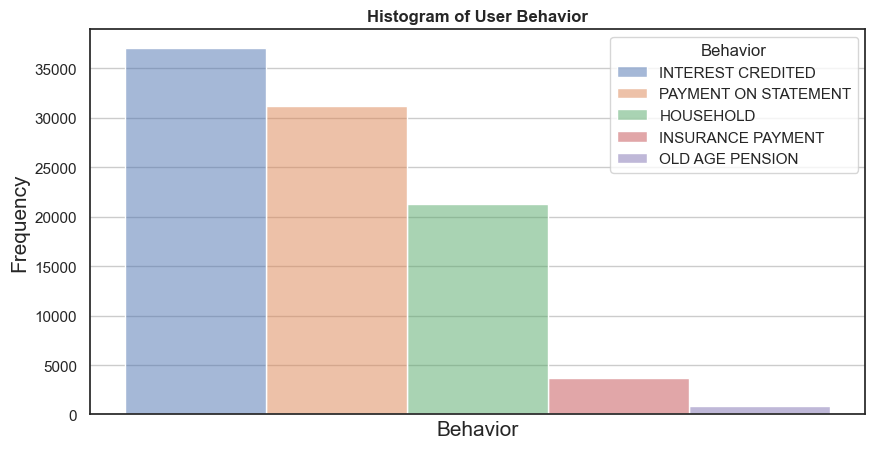

In [229]:
df_plot = d.copy()

# Change column name
df_plot.rename(columns={'k_symbol': 'Behavior'}, inplace=True)

# Filter the DataFrame for specific values in 'Behavior'
selected_values = ['INTEREST CREDITED','PAYMENT ON STATEMENT','HOUSEHOLD','INSURANCE PAYMENT','OLD AGE PENSION']
df_filtered = df_plot[df_plot['Behavior'].isin(selected_values)]

# Create a histogram using seaborn
plt.figure(figsize=(10, 5))  # Adjust the figure size if needed
sns.histplot(data=df_filtered, x='Behavior', bins=30, hue='Behavior', legend=True)

# Adding axis labels and customizing their font size
plt.xlabel('Behavior', fontsize=15)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylabel('Frequency', fontsize=15)
plt.xticks([])
plt.title('Histogram of User Behavior', fontweight='bold')

# Display the plot
plt.grid(True)
plt.show()

From this behavior analysis. We can conclude that most of the behacior is interest credited. This suggests that interest-related activities or transactions play a substantial role in the overall behavior being examined.

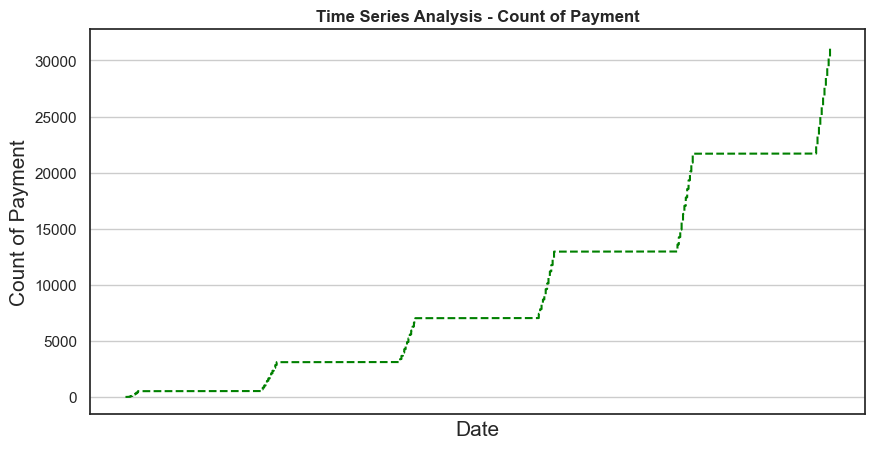

In [230]:
# Filter the DataFrame to include only 'PAYMENT ON STATEMENT' values
payment_on_statement_df = df_plot[df_plot['Behavior'] == 'PAYMENT ON STATEMENT']

# Check the data type of the 'date' column
payment_on_statement_df['date'] = pd.to_datetime(payment_on_statement_df['date'])

# Sort the DataFrame by date in ascending order (if not already sorted)
payment_on_statement_df.sort_values(by='date', inplace=True)

# Create a time series plot for the count of 'PAYMENT ON STATEMENT' occurrences over time
plt.figure(figsize=(10, 5))
plt.plot(payment_on_statement_df['date'], range(len(payment_on_statement_df)), c='green', linestyle='dashed')

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count of Payment', fontsize=15)
plt.xticks([])
plt.title('Time Series Analysis - Count of Payment', fontweight='bold')

# Display the plot
plt.grid(True)
plt.show()

From this visualization, we can conclude that the trend is uphill from time to time and reaches its peak at the end of the year. This suggests that perhaps the users spend their money during year-end sales.

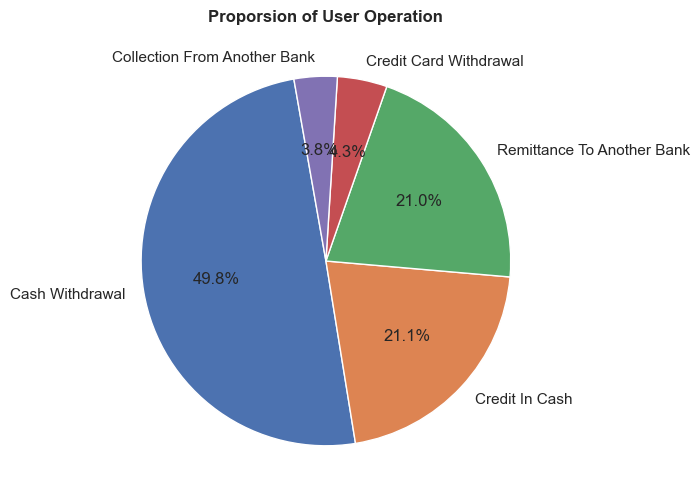

In [231]:
c_0 = d['operation'][d['operation'] == 'CASH WITHDRAWAL'].count()
c_1 = d['operation'][d['operation'] == 'CREDIT IN CASH'].count()
c_2 = d['operation'][d['operation'] == 'REMITTANCE TO ANOTHER BANK'].count()
c_3 = d['operation'][d['operation'] == 'CREDIT CARD WITHDRAWAL'].count()
c_4 = d['operation'][d['operation'] == 'COLLECTION FROM ANOTHER BANK'].count()

# Make pie chart
plt.figure(figsize=(6, 6))
plt.pie([c_0,c_1,c_2,c_3,c_4], labels=['Cash Withdrawal','Credit In Cash','Remittance To Another Bank','Credit Card Withdrawal','Collection From Another Bank'], autopct="%1.1f%%", startangle=100)
plt.title("Proporsion of User Operation", fontweight='bold')
plt.show()

From this visualization, we can see that almost 50% of user behavior involves cash withdrawals. We can utilize this information to formulate a strategy for customer segmentation.

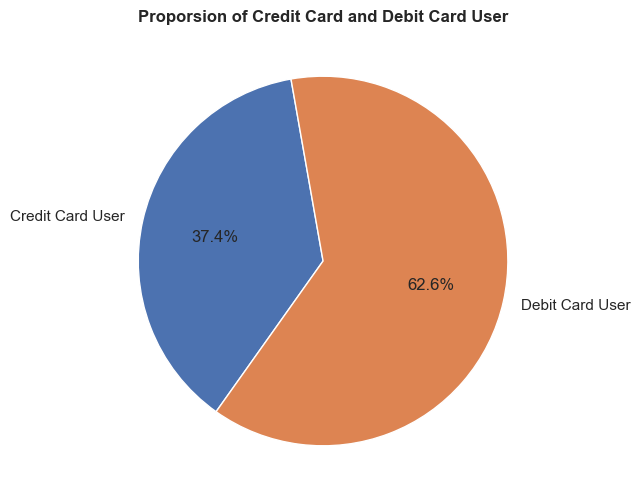

In [232]:
c_0 = d['type'][d['type'] == 'CREDIT'].count()
c_1 = d['type'][d['type'] == 'DEBIT'].count()

# Make pie chart
plt.figure(figsize=(6, 6))
plt.pie([c_0,c_1], labels=['Credit Card User','Debit Card User'], autopct="%1.1f%%", startangle=100)
plt.title("Proporsion of Credit Card and Debit Card User", fontweight='bold')
plt.show()

From this visualization, we can conclude that the number of debit card users is almost twice that of credit card users. We should focus on increasing the number of credit card users by promoting the value of our credit card.

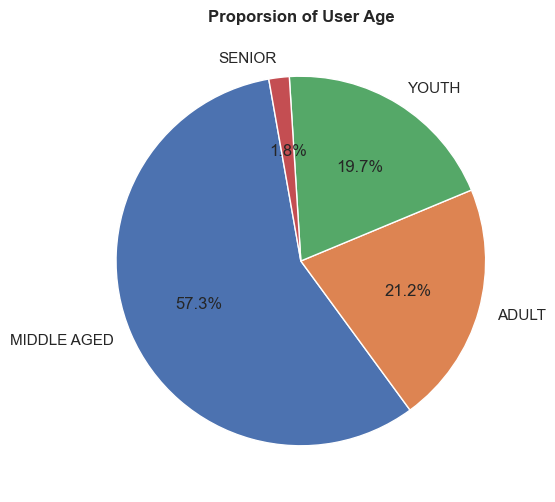

In [233]:
c_0 = d['age_levels'][d['age_levels'] == 'MIDDLE AGED'].count()
c_1 = d['age_levels'][d['age_levels'] == 'ADULT'].count()
c_2 = d['age_levels'][d['age_levels'] == 'YOUTH'].count()
c_3 = d['age_levels'][d['age_levels'] == 'SENIOR'].count()

# Make pie chart
plt.figure(figsize=(6, 6))
plt.pie([c_0,c_1,c_2,c_3], labels=['MIDDLE AGED','ADULT','YOUTH','SENIOR'], autopct="%1.1f%%", startangle=100)
plt.title("Proporsion of User Age", fontweight='bold')
plt.show()

From this visualization, we can see the age distribution in the data. We can conclude that the proportion of senior users is only 2.8% compared to other age groups. We can promote a pension package in hopes of attracting more senior users.

## 6. Feature Engineering

In this project, I'm going to calculate user transactions and behavior to create new columns. I'm doing this because we need to cluster the users, not the transactions.

In [234]:
transaction_summary = d.groupby('account_id').agg({
    'amount': 'sum',
    'balance': ['last', 'max', 'min', 'mean']
}).reset_index()

# Flatten the multi-level column names
transaction_summary.columns = ['account_id', 'total_transaction_amount', 'last_balance', 'max_balance', 'min_balance', 'average_balance']

# Create new columns 'debit_amount' and 'credit_amount' based on 'type_x'
d['debit_amount'] = d.apply(lambda row: row['amount'] if row['type'] == 'DEBIT' else 0, axis=1)
d['credit_amount'] = d.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else 0, axis=1)

# Create new columns for different transaction types
transaction_types = ['CASH WITHDRAWAL', 'REMITTANCE TO ANOTHER BANK', 'CREDIT IN CASH', 'COLLECTION FROM ANOTHER BANK', 'CREDIT CARD WITHDRAWAL']
transaction_symbols = ['INTEREST CREDITED','PAYMENT ON STATEMENT','HOUSEHOLD','INSURANCE PAYMENT','LOAN PAYMENT','OLD AGE PENSION','SANCTION INTEREST']

for transaction_symbol in transaction_symbols:
    d[f'{transaction_symbol}_total'] = d.apply(lambda row: row['amount'] if row['k_symbol'] == transaction_symbol else 0, axis=1)

for transaction_type in transaction_types:
    d[f'{transaction_type}_total'] = d.apply(lambda row: row['amount'] if row['operation'] == transaction_type else 0, axis=1)


# Group the data by 'account_id' and calculate the sum of transaction types
account_summary = d.groupby('account_id').agg({
    'debit_amount': 'sum',
    'credit_amount': 'sum',
    'CASH WITHDRAWAL_total': 'sum',
    'REMITTANCE TO ANOTHER BANK_total': 'sum',
    'CREDIT IN CASH_total': 'sum',
    'COLLECTION FROM ANOTHER BANK_total': 'sum',
    'CREDIT CARD WITHDRAWAL_total': 'sum',
    'INTEREST CREDITED_total': 'sum',
    'PAYMENT ON STATEMENT_total': 'sum',
    'HOUSEHOLD_total': 'sum',
    'INSURANCE PAYMENT_total': 'sum',
    'LOAN PAYMENT_total': 'sum',
    'OLD AGE PENSION_total': 'sum',
    'SANCTION INTEREST_total': 'sum'
}).reset_index()

# Merge the total transaction amount and balance back into the account_summary DataFrame
account_summary = account_summary.merge(transaction_summary, on='account_id', how='left')

# Print the resulting DataFrame
print(account_summary)

     account_id  debit_amount  credit_amount  CASH WITHDRAWAL_total  \
0             7    561772.000     630267.900             458272.000   
1            14    373272.000     412586.000             287692.000   
2            33   1559789.400    1672195.400            1268761.400   
3            34   2146258.000    2196372.500            1755112.000   
4            43   1390460.000    1451226.700             988010.000   
..          ...           ...            ...                    ...   
887       11079   1970066.800    2071824.000            1863768.800   
888       11138   2657781.800    2713804.200            2550009.000   
889       11141    801624.400     894583.900             743488.000   
890       11186   2068839.800    2153618.600            1447077.400   
891       11359   1436440.200    1511641.200            1105500.600   

     REMITTANCE TO ANOTHER BANK_total  CREDIT IN CASH_total  \
0                           97600.000            623775.000   
1                    

In [235]:
final_feature = pd.merge(client, account_summary, on='account_id')

In [236]:
df = final_feature.copy()

In [237]:
df

,client_id,birth_number,district_id,gender,age,age_levels,disp_id,account_id,type_x,card_id,...,HOUSEHOLD_total,INSURANCE PAYMENT_total,LOAN PAYMENT_total,OLD AGE PENSION_total,SANCTION INTEREST_total,total_transaction_amount,last_balance,max_balance,min_balance,average_balance
0,9,351016,60,MALE,64,MIDDLE AGED,9,7,OWNER,1,...,97600.000,0.000,0.000,0.000,0.000,1192039.900,68495.500,99675.300,900.000,62598.592
1,19,421228,47,MALE,57,MIDDLE AGED,19,14,OWNER,2,...,72580.000,0.000,0.000,0.000,0.000,785858.000,39313.900,59453.000,400.000,39603.633
2,41,680827,22,MALE,31,ADULT,41,33,OWNER,3,...,229628.000,0.000,0.000,0.000,0.000,3231984.800,112405.500,123696.300,600.000,72337.540
3,42,350817,68,MALE,64,MIDDLE AGED,42,34,OWNER,4,...,29116.000,0.000,0.000,0.000,0.000,4342630.500,50114.200,94579.700,600.000,53975.819
4,51,791202,36,FEMALE,20,YOUTH,51,43,OWNER,5,...,329450.000,0.000,0.000,0.000,0.000,2841686.700,60766.500,99571.800,1100.000,60897.162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,13620,700726,16,MALE,29,ADULT,13312,11079,OWNER,1230,...,0.000,0.000,98298.000,0.000,0.000,4041890.800,101756.800,146540.300,300.000,73271.688
888,13690,630516,70,MALE,36,MIDDLE AGED,13382,11138,OWNER,1233,...,0.000,0.000,89872.800,0.000,0.000,5371586.000,56023.000,168372.300,800.000,73259.424
889,13694,760120,1,FEMALE,23,YOUTH,13386,11141,OWNER,1234,...,0.000,0.000,44936.400,0.000,0.000,1696208.300,92960.000,144498.200,200.000,61940.018
890,13750,801113,12,FEMALE,19,YOUTH,13442,11186,OWNER,1239,...,441450.000,0.000,176612.400,0.000,0.000,4222458.400,84779.600,139172.500,900.000,67157.031


In [238]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
client_id,892.000,NaN,NaN,NaN,3538.104,3053.520,9.000,1387.000,2938.500,4459.500,13968.000
birth_number,892.000,NaN,NaN,NaN,590081.994,144529.121,180216.000,461116.000,590727.000,720510.500,820907.000
district_id,892.000,NaN,NaN,NaN,34.360,24.834,1.000,10.000,34.000,56.000,77.000
gender,892,2,MALE,469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,892.000,NaN,NaN,NaN,40.057,14.454,17.000,27.000,40.000,53.000,81.000
age_levels,892,4,MIDDLE AGED,504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
disp_id,892.000,NaN,NaN,NaN,3511.862,2984.374,9.000,1387.000,2938.500,4459.500,13660.000
account_id,892.000,NaN,NaN,NaN,2913.401,2486.298,7.000,1153.250,2432.500,3698.250,11359.000
type_x,892,1,OWNER,892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card_id,892.000,NaN,NaN,NaN,480.855,306.934,1.000,229.750,456.500,684.250,1247.000


In this dataset, there are 31 features, including the user IDs. We're going to reduce it by selecting correlated features and by using PCA.

### 6.1 Handling Missing Value

Handling missing values by changing the value to 0. We don't want to remove the missing values because we still need to observe users' behavior.

In [239]:
df = df.fillna(0)

In [240]:
# split between numerical and categorical
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
# categorical and numerical to dataframe
num = df[num_cols]

### 6.2 Finding Feature Correlation

Selecting correlated feature that contain mopre than 50 percent correlation

In [241]:
corr = num.corr()

In [242]:
def pearson_correlation(x, y):

  # Find the mean of each array.
  x_mean = np.mean(x)
  y_mean = np.mean(y)

  # Find the covariance of the two arrays.
  covariance = np.cov(x, y)[0, 1]

  # Find the standard deviation of each array.
  x_std = np.std(x)
  y_std = np.std(y)

  # Calculate the Pearson correlation coefficient.
  r = covariance / (x_std * y_std)

  return r

In [243]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

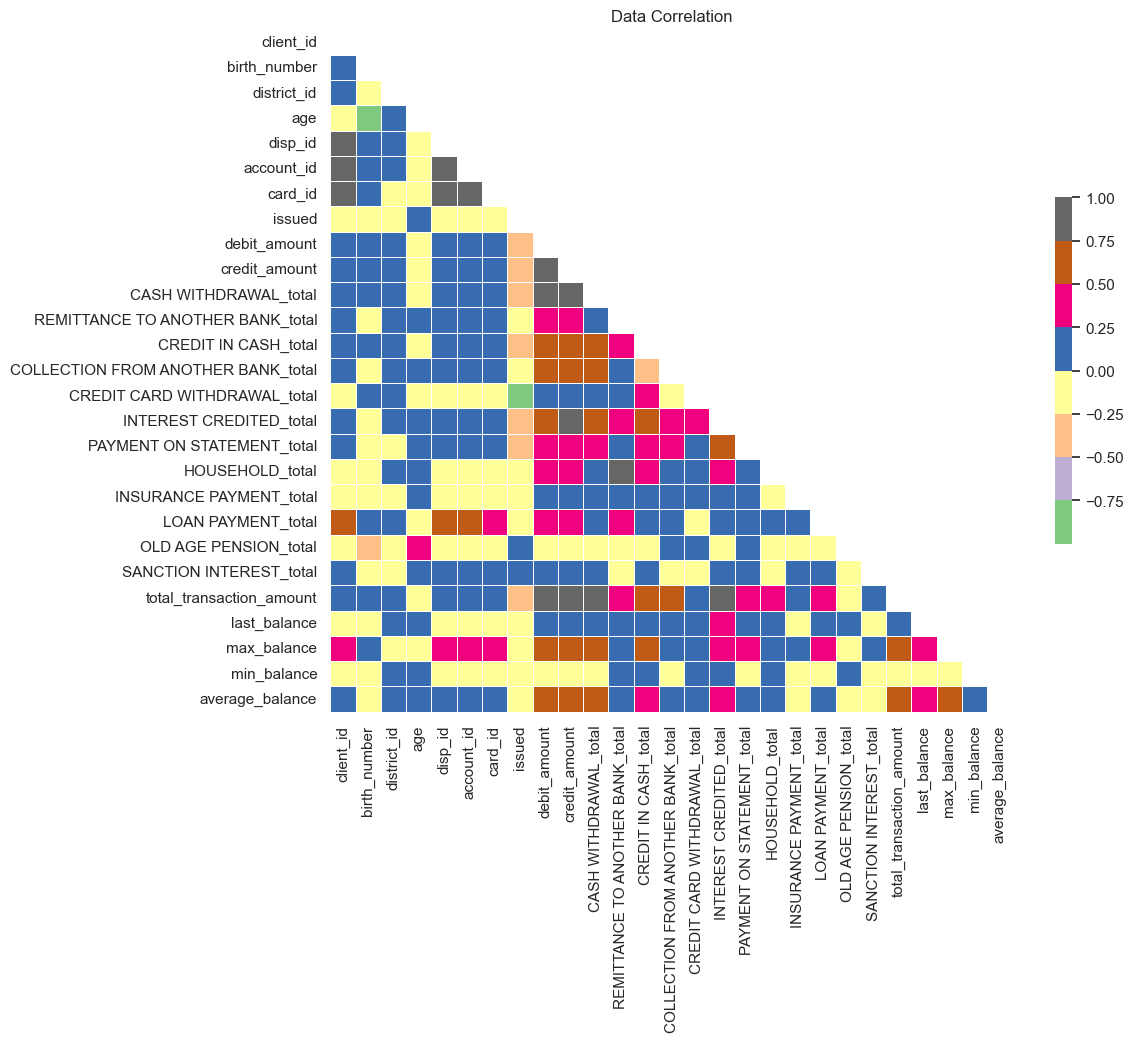

In [244]:
# Visualization
sns.set(style='white')
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap='Accent', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# show threshold number in visualization

plt.title('Data Correlation')
plt.show()

In [245]:
# get the columns that have more than 0.7 correlation
corr_cols = corr[corr > 0.5]
corr_cols

,client_id,birth_number,district_id,age,disp_id,account_id,card_id,issued,debit_amount,credit_amount,...,HOUSEHOLD_total,INSURANCE PAYMENT_total,LOAN PAYMENT_total,OLD AGE PENSION_total,SANCTION INTEREST_total,total_transaction_amount,last_balance,max_balance,min_balance,average_balance
client_id,1.000,NaN,NaN,NaN,1.000,1.000,0.955,NaN,NaN,NaN,...,NaN,NaN,0.504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_number,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
district_id,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
disp_id,1.000,NaN,NaN,NaN,1.000,1.000,0.959,NaN,NaN,NaN,...,NaN,NaN,0.502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account_id,1.000,NaN,NaN,NaN,1.000,1.000,0.958,NaN,NaN,NaN,...,NaN,NaN,0.502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card_id,0.955,NaN,NaN,NaN,0.959,0.958,1.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
issued,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
debit_amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,1.000,NaN,0.690,NaN,0.537
credit_amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000,1.000,...,NaN,NaN,NaN,NaN,NaN,1.000,NaN,0.694,NaN,0.549


### 6.3 Feature Selection

I used a threshold of < 0.5 for feature correlation and selected the features listed below to build the model. Excluding the columns from transaction type.

In [246]:
num = num[['CASH WITHDRAWAL_total', 'CREDIT IN CASH_total', 'COLLECTION FROM ANOTHER BANK_total', 'max_balance', 'total_transaction_amount', 'average_balance', 'total_transaction_amount', 'credit_amount', 'debit_amount']]

### Feature Scaling

I'm using StandardScaler to scale the features because we have negative values, and we want to standardize the data.

In [247]:
# Defining the Feature Scaler
scaler = StandardScaler()
Xscaled = scaler.fit_transform(num)

numerical_col = pd.DataFrame(Xscaled)

### 6.4 PCA

Using PCA to reducing the data dimensionality

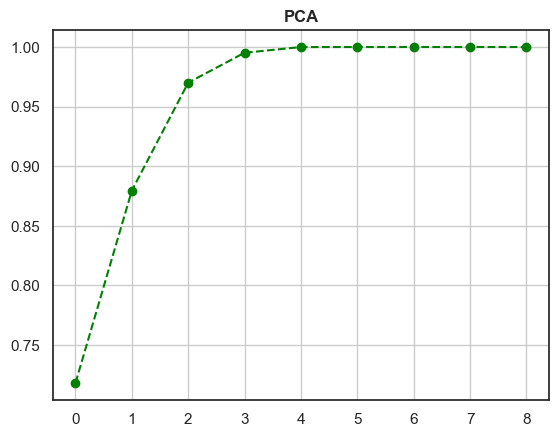

In [248]:
pca_model=PCA()
pca_model.fit(numerical_col)
cumsum = np.cumsum(pca_model.explained_variance_ratio_)

plt.plot(cumsum, '--o', c='Green')
plt.title('PCA', fontweight='bold')
plt.grid()
plt.show()

Based on the PCA visualization, three features are perfect for the model because they account for more than a 98 percent variance ratio.

In [249]:
pca_model.explained_variance_ratio_

array([7.18226948e-01, 1.61397922e-01, 9.04861874e-02, 2.50719525e-02,
       4.77007102e-03, 4.62922254e-05, 6.26114569e-07, 1.63453906e-32,
       9.64785167e-37])

In [250]:
pca = PCA(n_components=0.95).fit_transform(numerical_col)

In [251]:
X_pca_df = pd.DataFrame(pca)
X_pca_df

,0,1,2
0,-1.060,-0.311,1.236
1,-2.571,0.247,-0.680
2,2.258,-1.173,0.896
3,3.020,3.097,-0.674
4,1.131,-0.809,0.029
...,...,...,...
887,3.705,2.455,1.548
888,5.943,-2.040,0.143
889,0.123,-0.704,1.520
890,3.466,2.587,0.994


Based on the PCA we can use 3 dimension out of 9 dimension.

## 7. Model Definition

In this unsupervised learning project, we're going to use K-means to segment the users.

In [252]:
kmeans = KMeans(n_clusters=4,random_state=50)

## 8. Model Evaluation

### 8.1 Evaluation Metrics

In [253]:
# Function for evaluate metrics
K=[2,3,4,5,6,7,8,9,10,11,12]
def evaluate_metrics(df, min_clust=2, max_clust=12, rand_state=50):
    inertias = []
    silhouette = []
    ch_score = []
    db_score = []
    for n_clust in range(min_clust, max_clust):
        kmeans = KMeans(n_clusters=n_clust, random_state=rand_state)
        y_label = kmeans.fit_predict(pca)
        inertias.append(kmeans.inertia_)
        silhouette.append(silhouette_score(pca, y_label))
        ch_score.append(calinski_harabasz_score(pca, y_label))
        db_score.append(davies_bouldin_score(pca, y_label))        

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    ax[0][0].plot(range(min_clust, max_clust), inertias, 'o--', c='Green')
    ax[0][0].set_xlabel('No. of clusters')
    ax[0][0].set_ylabel('Inertia')
    ax[0][0].grid()
    
    ax[0][1].plot(range(min_clust, max_clust), silhouette, 'o--', c='Green')
    ax[0][1].set_xlabel('No. of clusters')
    ax[0][1].set_ylabel('Silhouette Score')
    ax[0][1].grid()
    
    ax[1][0].plot(range(min_clust, max_clust), ch_score, 'o--', c='Green')
    ax[1][0].set_xlabel('No. of clusters')
    ax[1][0].set_ylabel('Calinski Harabasz Score')
    ax[1][0].grid()
    
    ax[1][1].plot(range(min_clust, max_clust), db_score, 'o--',c='Green')
    ax[1][1].set_xlabel('No. of clusters')
    ax[1][1].set_ylabel('Davies Bouldin Score')
    ax[1][1].grid()
    
    fig.suptitle('Metrics to evaluate the number of clusters', fontweight='bold')
    plt.show()

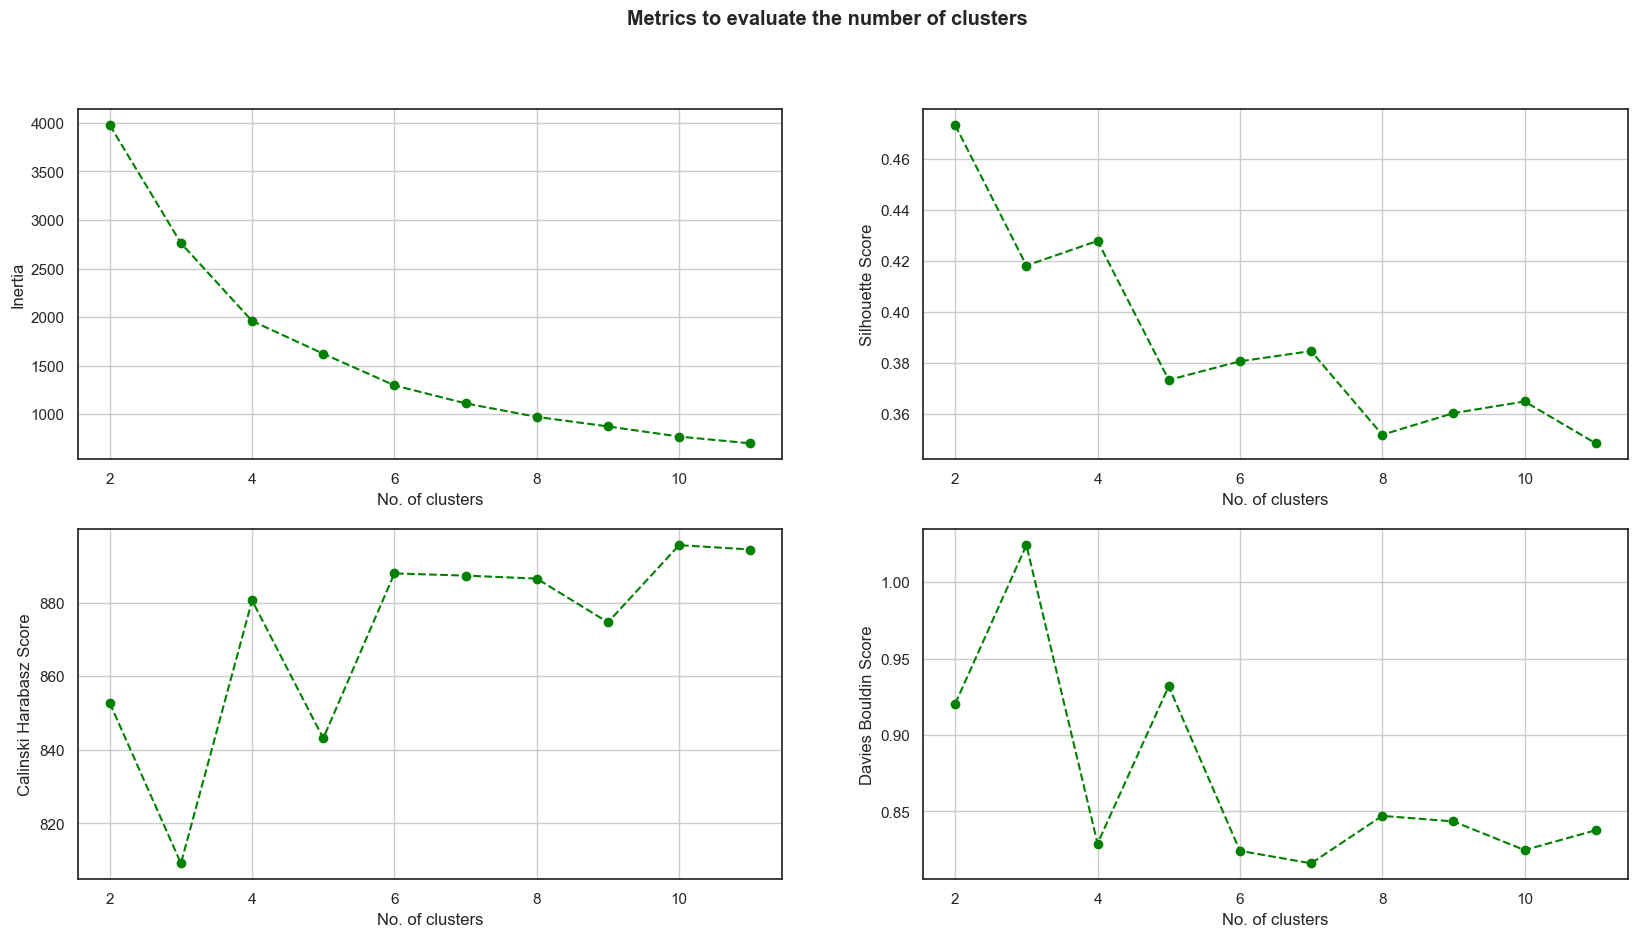

In [254]:
# Plot evaluate metrics
evaluate_metrics(pca, min_clust=2, max_clust=12, rand_state=50)

1. In the silhouette score, the model shows the highest score at 2 clusters, and the second-highest score is at 4 clusters.

2. In the Davies Bouldin Score, the model has a decline at 4 clusters, which is a better choice since lower values are preferable.

3. In the Calinski Harabasz Score, there is a spike at 4 clusters, which is better because higher values are preferred.

From this conclusion. I'm gonna pick 4 clusters for the model.

### 8.2 Plotting Silhouette Score

For n_clusters = 2 The average silhouette_score is : 0.473137826884091
For n_clusters = 3 The average silhouette_score is : 0.41814109256264453
For n_clusters = 4 The average silhouette_score is : 0.4278072069033675
For n_clusters = 5 The average silhouette_score is : 0.3722699927718587
For n_clusters = 6 The average silhouette_score is : 0.3805803436499992
For n_clusters = 7 The average silhouette_score is : 0.3838354887253802
For n_clusters = 8 The average silhouette_score is : 0.35027742044370563
For n_clusters = 9 The average silhouette_score is : 0.3600026523279552
For n_clusters = 10 The average silhouette_score is : 0.36691198268823516
For n_clusters = 11 The average silhouette_score is : 0.35104198882415866
For n_clusters = 12 The average silhouette_score is : 0.33781927988220706


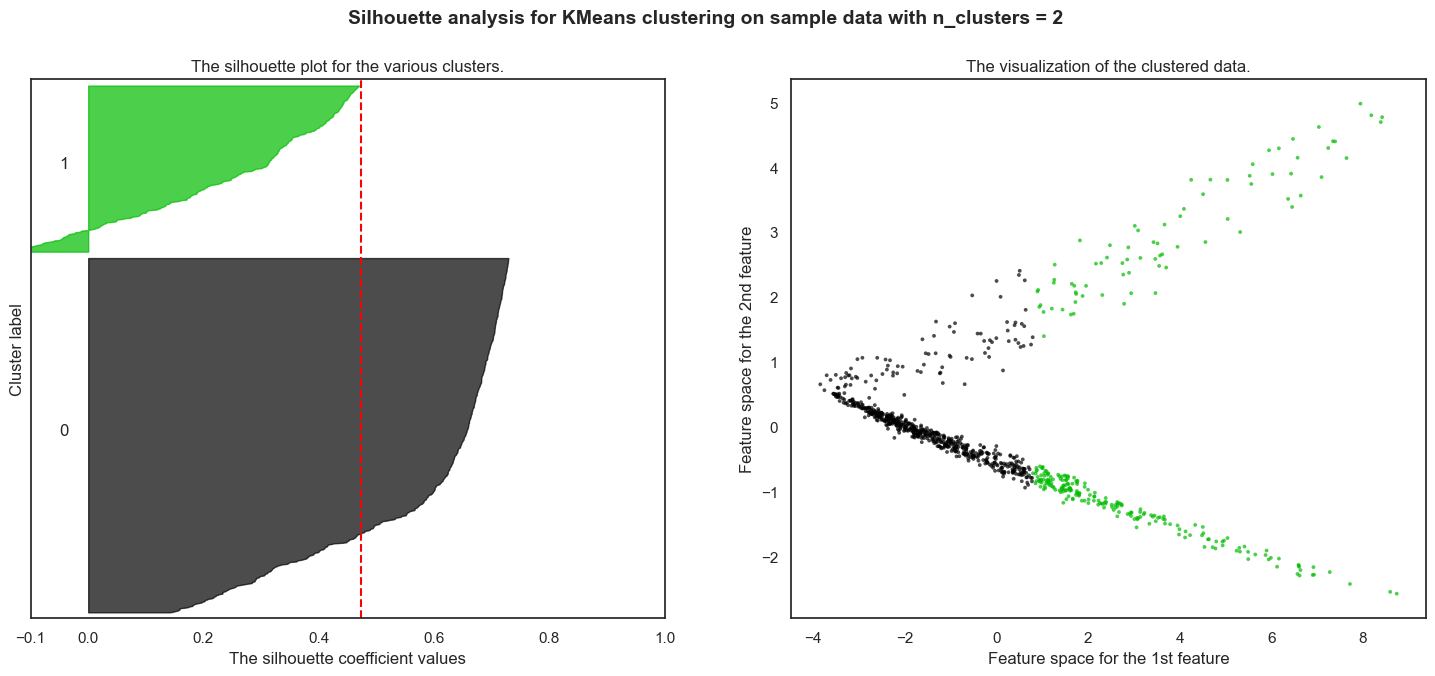

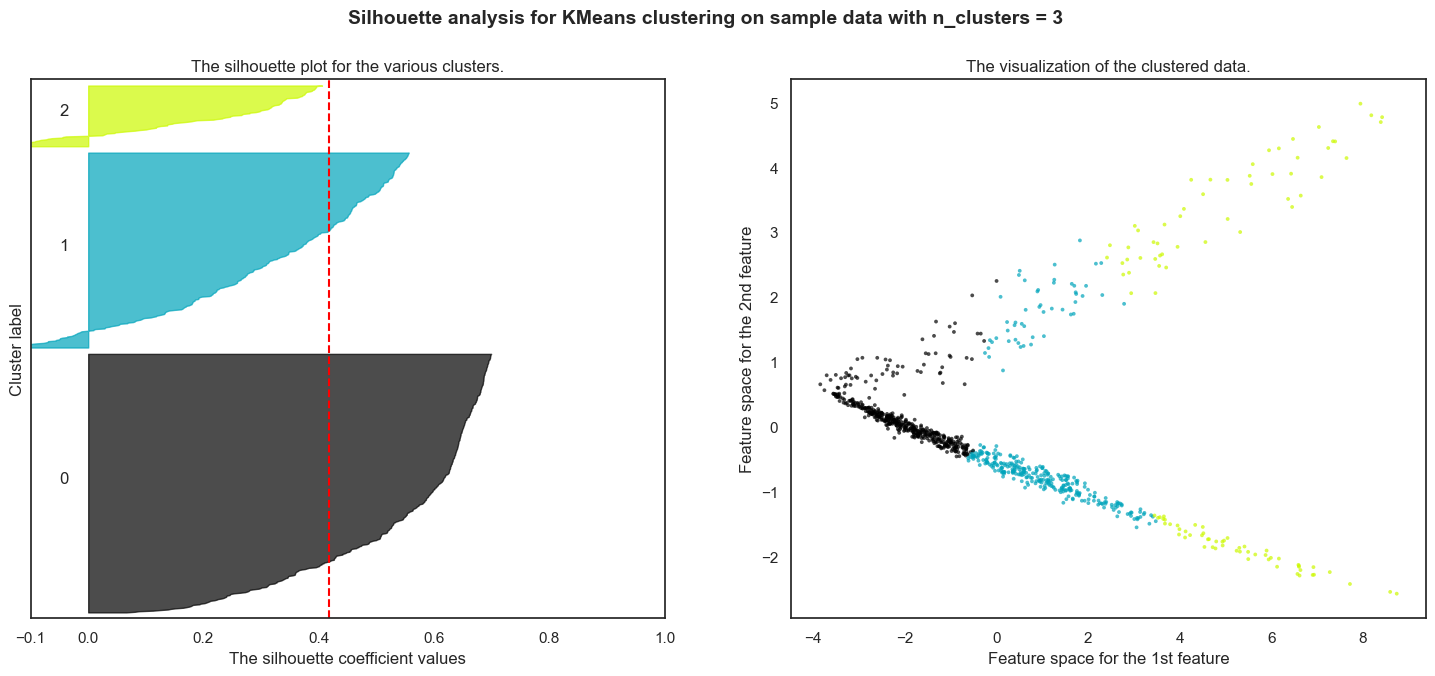

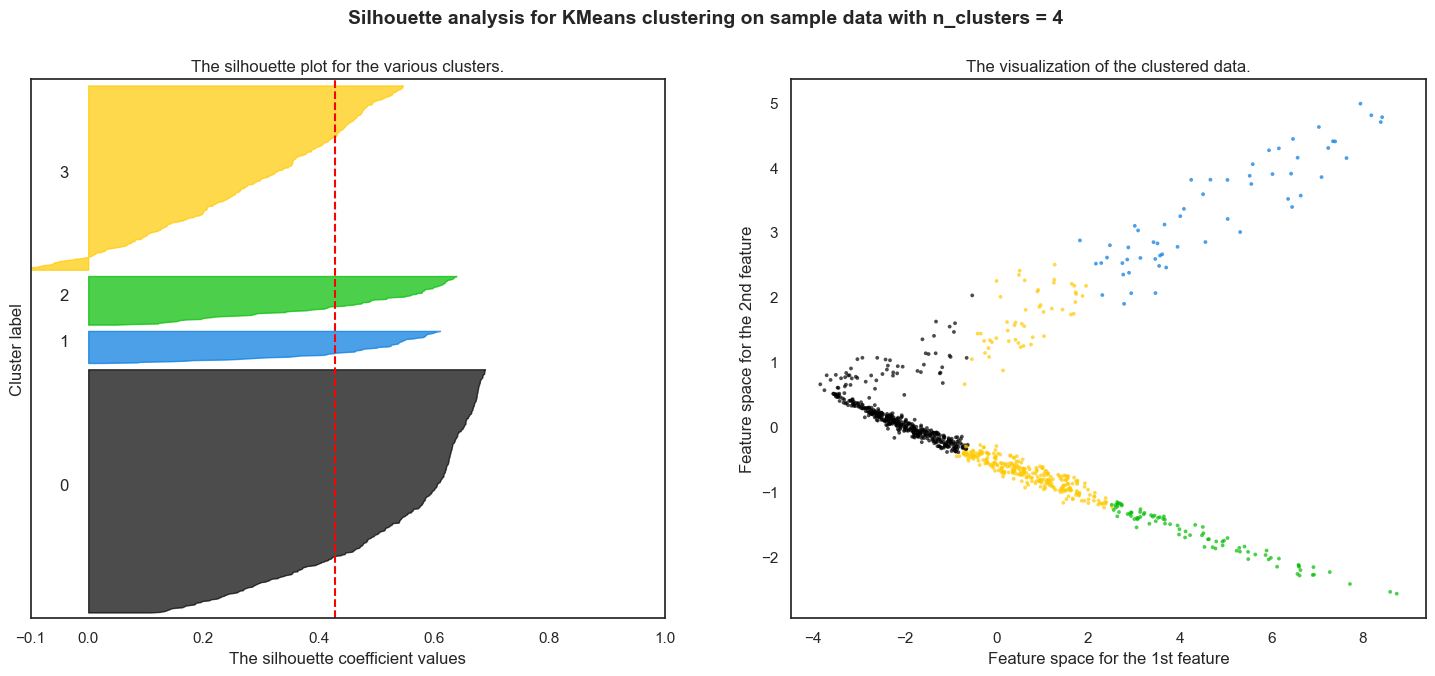

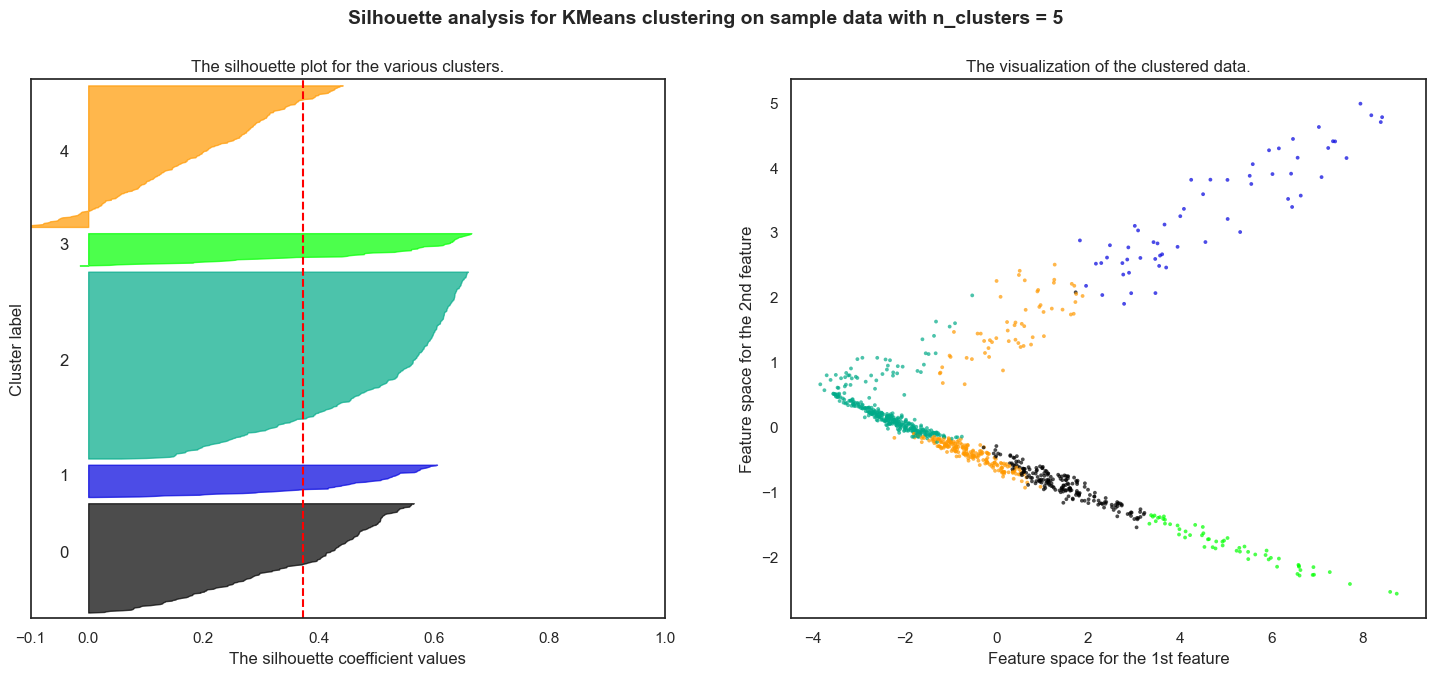

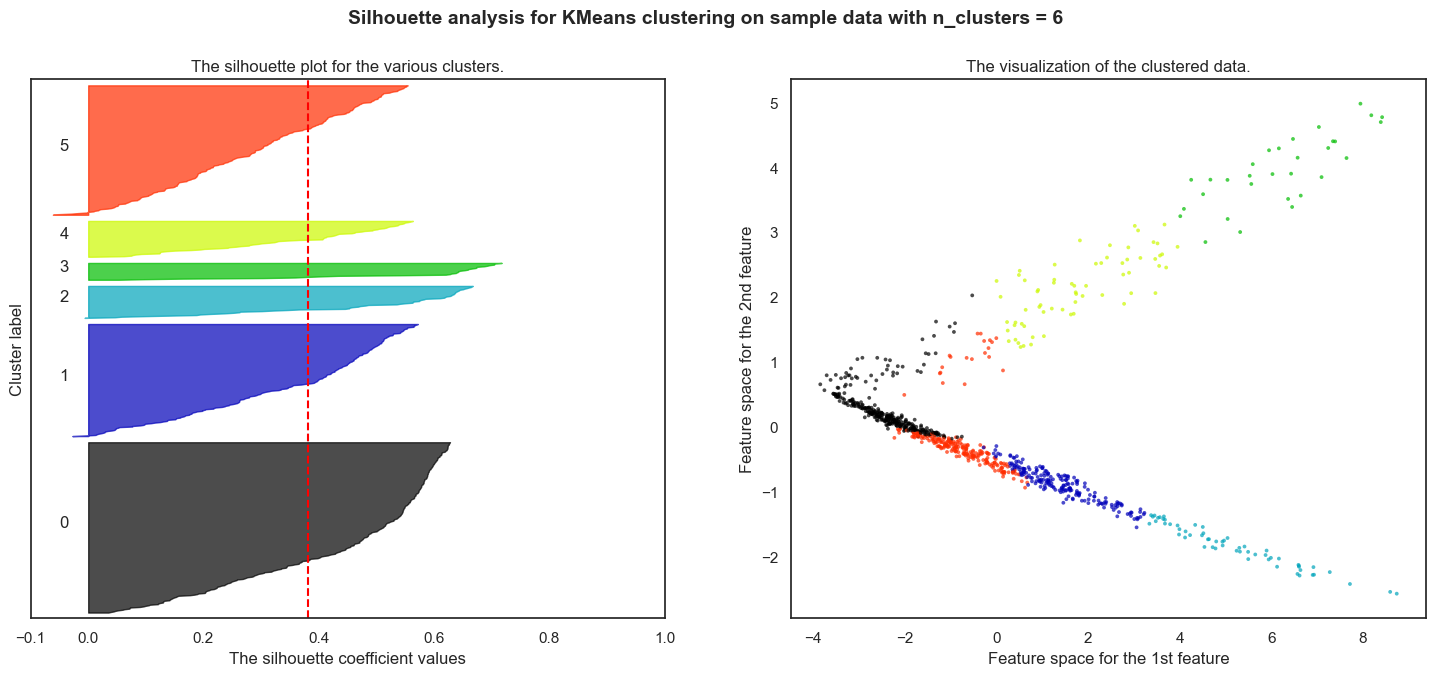

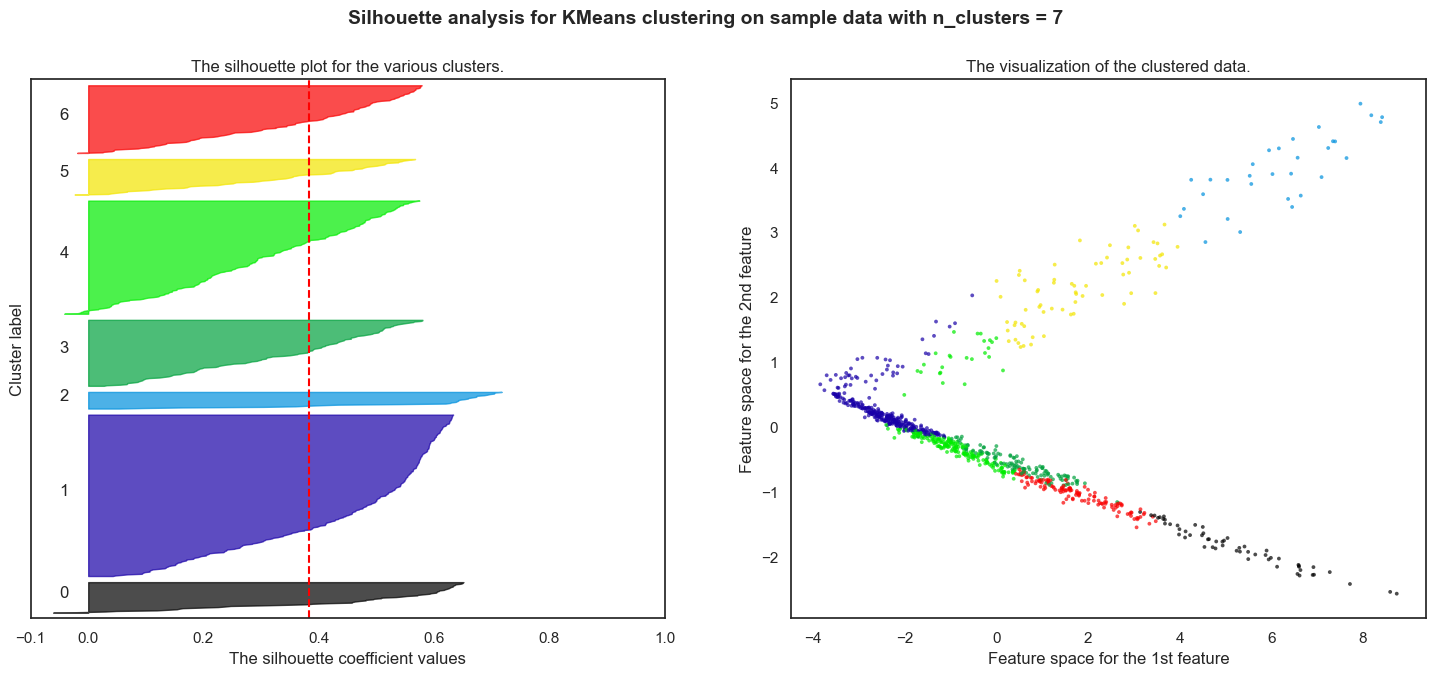

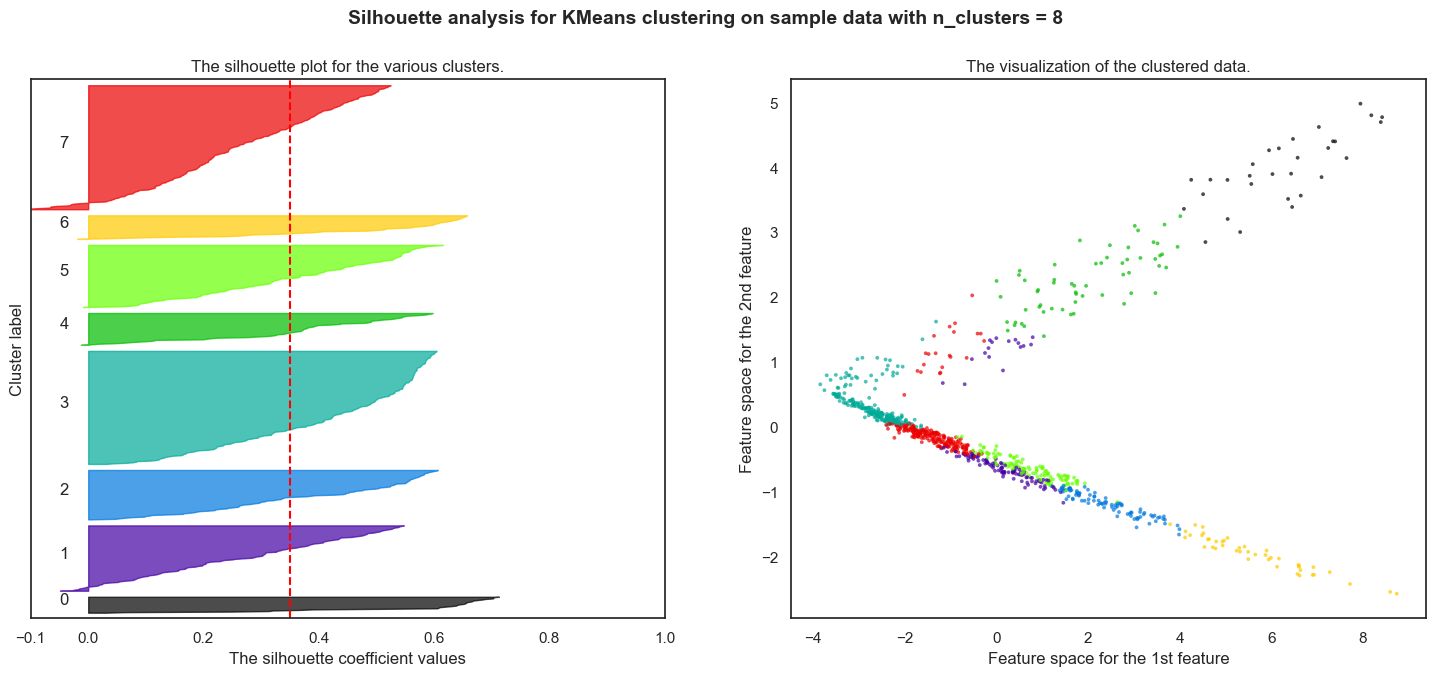

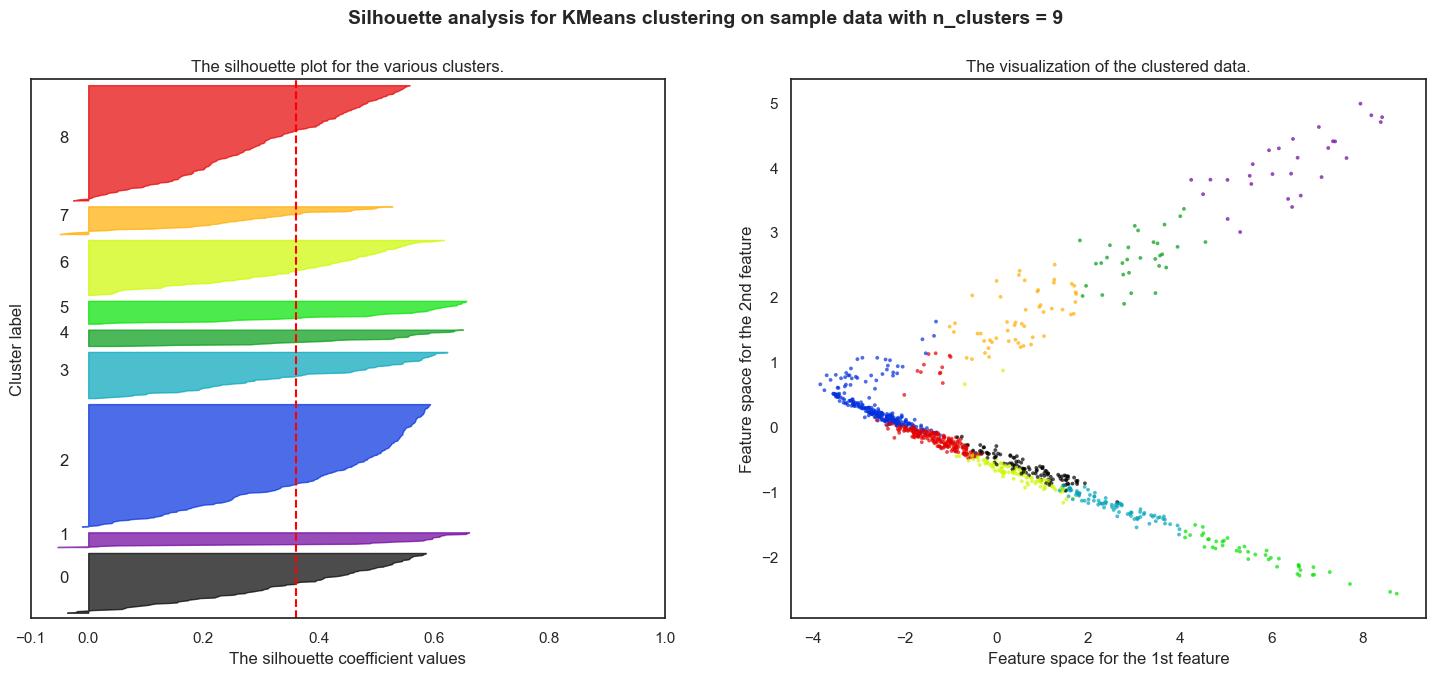

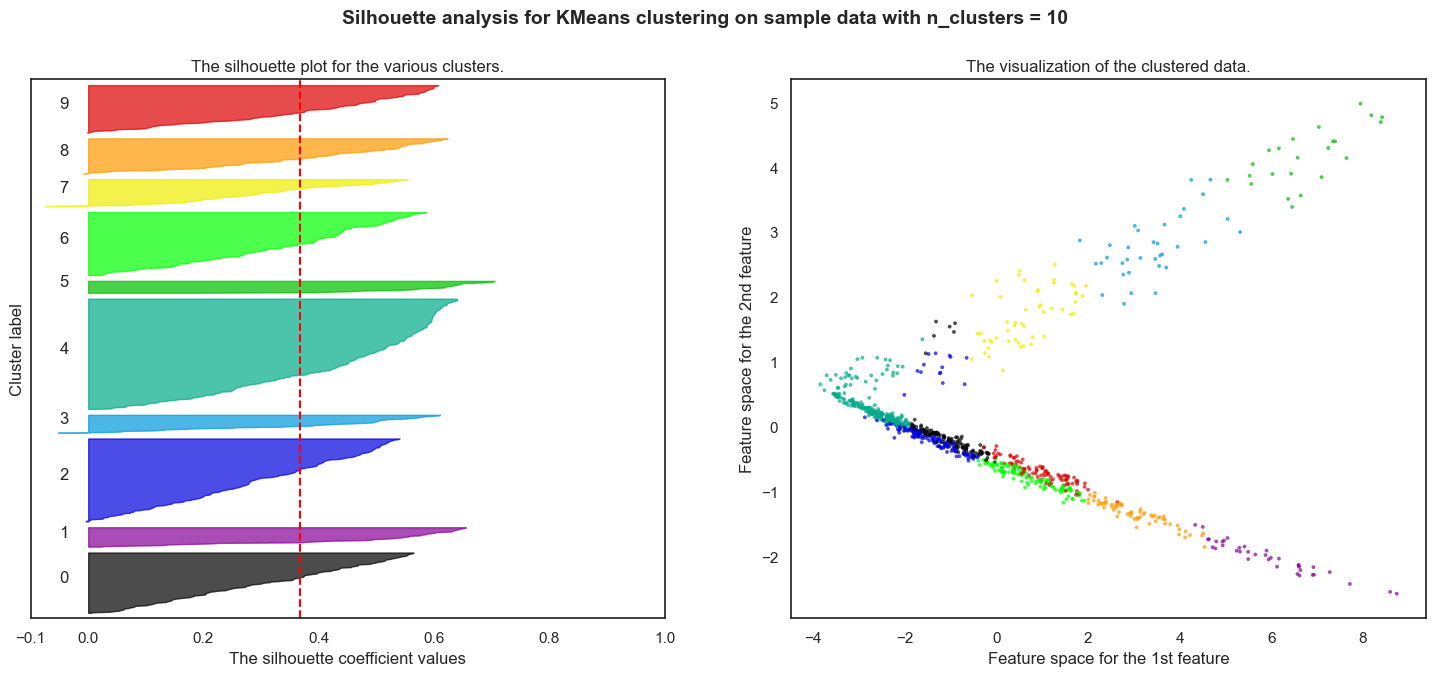

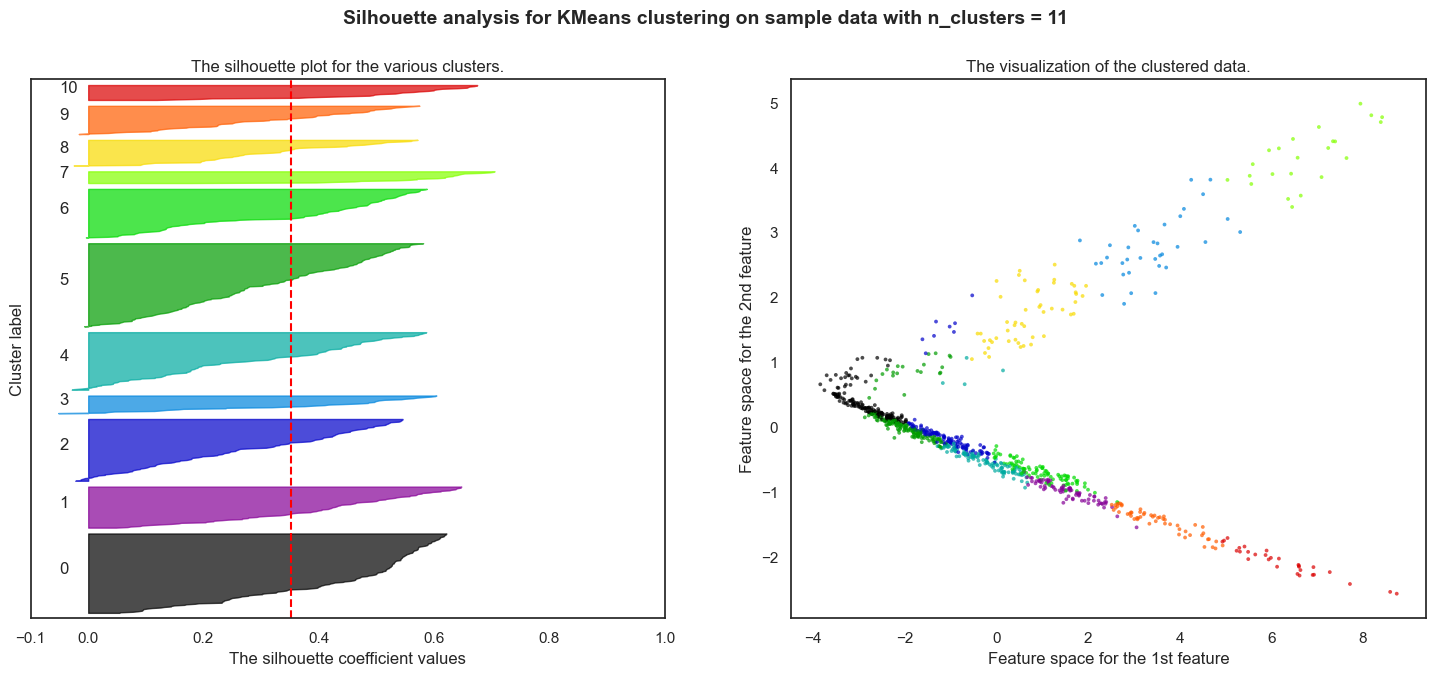

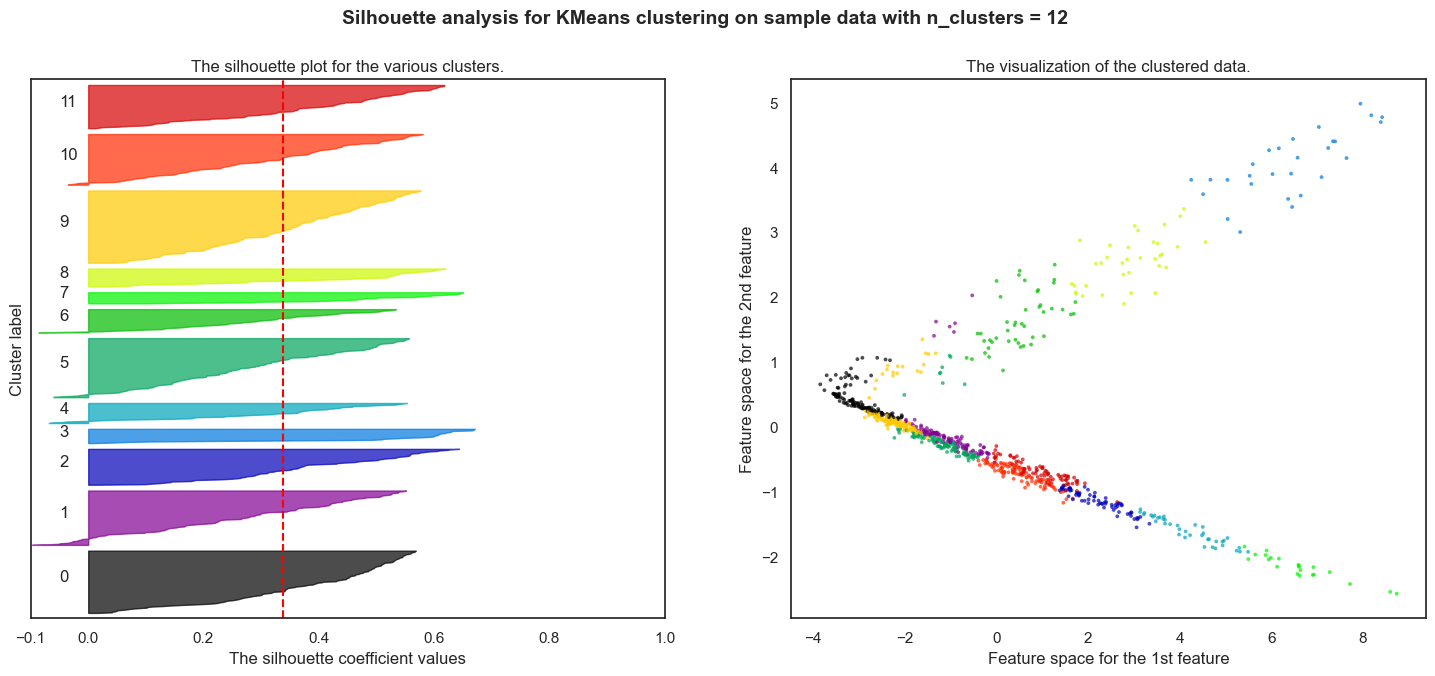

In [255]:
# Plot Silhouette Function
def plot_silhouette(model,range_n_clusters,X,model_name):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = model(n_clusters=n_clusters)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')


        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle((f"Silhouette analysis for {model_name} clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

plot_silhouette(KMeans,K,X_pca_df.values,'KMeans')

Based on the silhouette score, the highest score is for 2 clusters. However, we're going to choose 4 clusters based on the previous metrics.

## 9. Model Analysis

In [256]:
df_Kmeans = df.copy()

In [257]:
# Add clustering result column
np.random.seed(20)
km = kmeans.fit(pca)
df_Kmeans['Cluster'] = km.labels_

In [258]:
df_Kmeans

,client_id,birth_number,district_id,gender,age,age_levels,disp_id,account_id,type_x,card_id,...,INSURANCE PAYMENT_total,LOAN PAYMENT_total,OLD AGE PENSION_total,SANCTION INTEREST_total,total_transaction_amount,last_balance,max_balance,min_balance,average_balance,Cluster
0,9,351016,60,MALE,64,MIDDLE AGED,9,7,OWNER,1,...,0.000,0.000,0.000,0.000,1192039.900,68495.500,99675.300,900.000,62598.592,3
1,19,421228,47,MALE,57,MIDDLE AGED,19,14,OWNER,2,...,0.000,0.000,0.000,0.000,785858.000,39313.900,59453.000,400.000,39603.633,3
2,41,680827,22,MALE,31,ADULT,41,33,OWNER,3,...,0.000,0.000,0.000,0.000,3231984.800,112405.500,123696.300,600.000,72337.540,1
3,42,350817,68,MALE,64,MIDDLE AGED,42,34,OWNER,4,...,0.000,0.000,0.000,0.000,4342630.500,50114.200,94579.700,600.000,53975.819,0
4,51,791202,36,FEMALE,20,YOUTH,51,43,OWNER,5,...,0.000,0.000,0.000,0.000,2841686.700,60766.500,99571.800,1100.000,60897.162,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,13620,700726,16,MALE,29,ADULT,13312,11079,OWNER,1230,...,0.000,98298.000,0.000,0.000,4041890.800,101756.800,146540.300,300.000,73271.688,0
888,13690,630516,70,MALE,36,MIDDLE AGED,13382,11138,OWNER,1233,...,0.000,89872.800,0.000,0.000,5371586.000,56023.000,168372.300,800.000,73259.424,2
889,13694,760120,1,FEMALE,23,YOUTH,13386,11141,OWNER,1234,...,0.000,44936.400,0.000,0.000,1696208.300,92960.000,144498.200,200.000,61940.018,1
890,13750,801113,12,FEMALE,19,YOUTH,13442,11186,OWNER,1239,...,0.000,176612.400,0.000,0.000,4222458.400,84779.600,139172.500,900.000,67157.031,0


In [259]:
df_Kmeans['Cluster'].value_counts()

Cluster
3    426
1    323
2     86
0     57
Name: count, dtype: int64

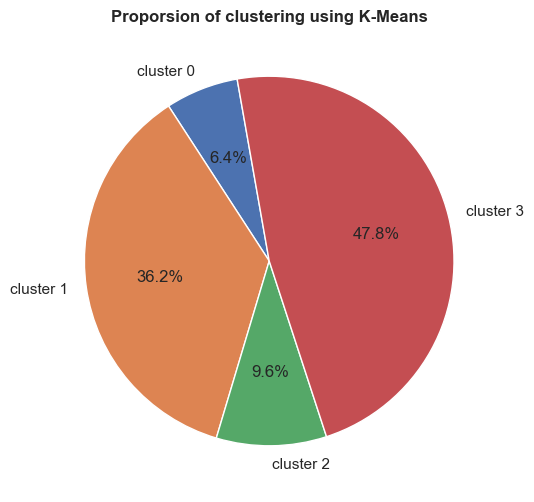

In [260]:
cl_0  = df_Kmeans['Cluster'][df_Kmeans['Cluster'] == 0].count()
cl_1  = df_Kmeans['Cluster'][df_Kmeans['Cluster'] == 1].count()
cl_2  = df_Kmeans['Cluster'][df_Kmeans['Cluster'] == 2].count()
cl_3  = df_Kmeans['Cluster'][df_Kmeans['Cluster'] == 3].count()

# Make pie chart
plt.figure(figsize=(6, 6))
plt.pie([cl_0,cl_1,cl_2,cl_3], labels=['cluster 0','cluster 1','cluster 2','cluster 3'], autopct="%1.1f%%", startangle=100)
plt.title("Proporsion of clustering using K-Means", fontweight='bold')
plt.show()

From the visualization, we can see that 
- Cluster 0 has the fewest users, which is 57 users.
- Cluster 1 has 87 users.
- Cluster 2 has 323 users.
- Cluster 3 has the most users, which is 426.

In [261]:
df_Kmeans.columns

Index(['client_id', 'birth_number', 'district_id', 'gender', 'age',
       'age_levels', 'disp_id', 'account_id', 'type_x', 'card_id', 'type_y',
       'issued', 'debit_amount', 'credit_amount', 'CASH WITHDRAWAL_total',
       'REMITTANCE TO ANOTHER BANK_total', 'CREDIT IN CASH_total',
       'COLLECTION FROM ANOTHER BANK_total', 'CREDIT CARD WITHDRAWAL_total',
       'INTEREST CREDITED_total', 'PAYMENT ON STATEMENT_total',
       'HOUSEHOLD_total', 'INSURANCE PAYMENT_total', 'LOAN PAYMENT_total',
       'OLD AGE PENSION_total', 'SANCTION INTEREST_total',
       'total_transaction_amount', 'last_balance', 'max_balance',
       'min_balance', 'average_balance', 'Cluster'],
      dtype='object')

In [262]:
no_of_clusters = df_Kmeans.groupby(by='Cluster')
# definine columns
age = no_of_clusters['age'].mean()
debit_amount = no_of_clusters['debit_amount'].mean()
credit_amount = no_of_clusters['credit_amount'].mean()
cash_withdrawal_total = no_of_clusters['CASH WITHDRAWAL_total'].mean()
remittance_to_another_bank_total = no_of_clusters['REMITTANCE TO ANOTHER BANK_total'].mean()
credit_in_cash_total = no_of_clusters['CREDIT IN CASH_total'].mean()
collection_from_another_bank_total = no_of_clusters['COLLECTION FROM ANOTHER BANK_total'].mean()
credit_card_withdrawal_total = no_of_clusters['CREDIT CARD WITHDRAWAL_total'].mean()
total_transaction_amount = no_of_clusters['total_transaction_amount'].mean()
last_balance = no_of_clusters['last_balance'].mean()
max_balance = no_of_clusters['max_balance'].mean()
average_balance = no_of_clusters['average_balance'].mean()
interest_credited_total = no_of_clusters['INTEREST CREDITED_total'].mean()
payment_on_statement_total = no_of_clusters['PAYMENT ON STATEMENT_total'].mean()
household_total = no_of_clusters['HOUSEHOLD_total'].mean()
insurance_payment_total = no_of_clusters['INSURANCE PAYMENT_total'].mean()
loan_payment_total = no_of_clusters['LOAN PAYMENT_total'].mean()
old_age_pension_total = no_of_clusters['OLD AGE PENSION_total'].mean()
sanction_interest_total = no_of_clusters['SANCTION INTEREST_total'].mean()

In [263]:
vis_cluster_analysis_df = pd.concat([pd.Series([0,1,2,4]),
                                   age,
                                   debit_amount,
                                   credit_amount,
                                   cash_withdrawal_total,
                                   remittance_to_another_bank_total,
                                   credit_in_cash_total,
                                   collection_from_another_bank_total,
                                   credit_card_withdrawal_total,
                                   total_transaction_amount,
                                   last_balance,
                                   max_balance,
                                   average_balance,
                                   interest_credited_total,
                                   payment_on_statement_total,
                                   household_total,
                                   insurance_payment_total,
                                   loan_payment_total,
                                   old_age_pension_total,
                                   sanction_interest_total],axis=1)

In [264]:
vis_cluster_analysis_df.columns = ['Cluster',
                                   'age',
                                   'debit_amount',
                                   'credit_amount',
                                   'cash_withdrawal_total',
                                   'remittance_to_another_bank_total',
                                   'credit_in_cash_total',
                                   'collection_from_another_bank_total',
                                   'credit_card_withdrawal_total',
                                   'total_transaction_amount',
                                   'last_balance',
                                   'max_balance',
                                   'average_balance',
                                   'interest_credited_total',
                                   'payment_on_statement_total',
                                   'household_total',
                                   'insurance_payment_total',
                                   'loan_payment_total',
                                   'old_age_pension_total',
                                   'sanction_interest_total']

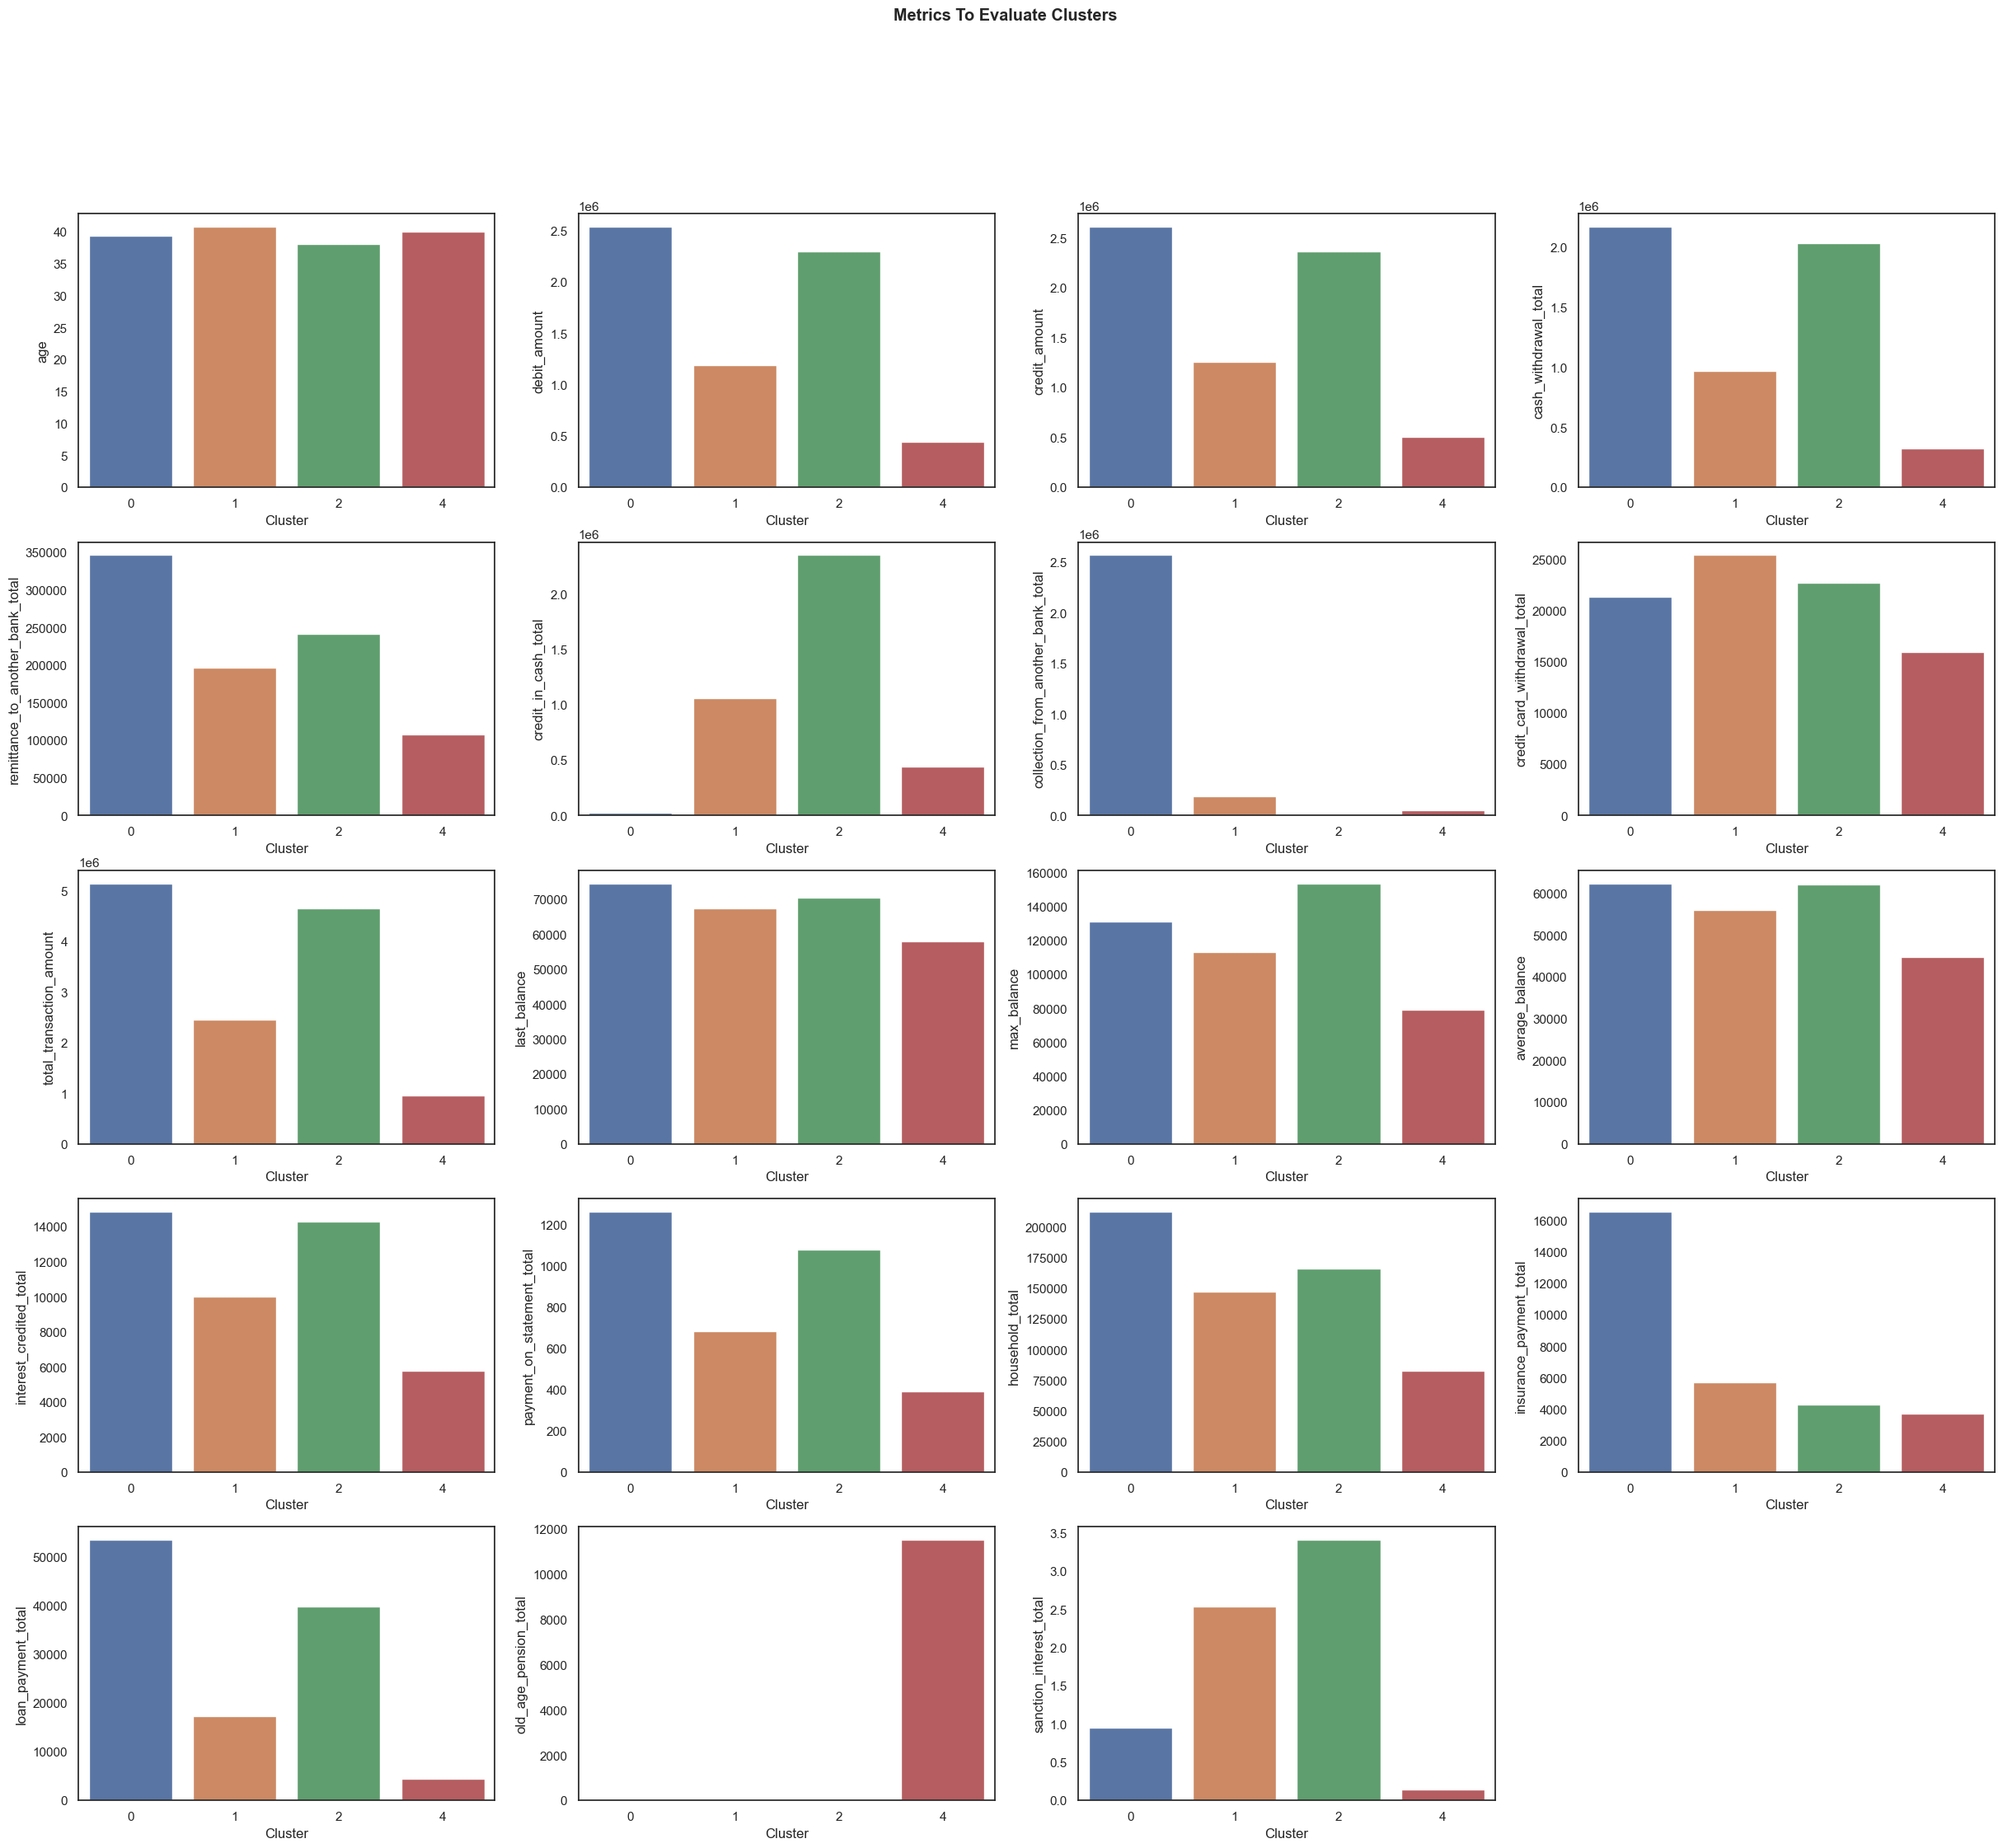

In [265]:
fig = plt.figure(figsize=(30,25))
   
for plot, feature in enumerate(vis_cluster_analysis_df.columns[1:]):
    fig.add_subplot(5,4,plot+1)
    sns.barplot(x=vis_cluster_analysis_df['Cluster'], y=vis_cluster_analysis_df[feature])
    fig.suptitle('Metrics To Evaluate Clusters', fontweight='bold')

From this visualization, we can conclude that.

**Cluster 0** : 
- High Debit Amount
- High Credit Amount
- High Cash Withdrawal total
- High Remittance to another bank
- Low Credit in cash total
- High Collection from another bank total
- Medium credit card withdrawal total
- High Transaction Amount
- High Last Balance
- Medium Max Balance
- High Average Balance
- High Intereest Credited Total
- High Payment on Statement Total
- High Household Total
- High Insurance Payment Total
- High Loan Payment Total
- Low Old Age Pension Total 
- Moderate Sanction Interest Total

**Cluster 1** : 
- Moderate Debit Amount
- Moderate Credit Amount
- Moderate Cash Withdrawal total
- Moderate Remittance to another bank
- Moderate Credit in cash total
- Low Collection from another bank total
- High credit card withdrawal total
- Moderate Transaction Amount
- High Last Balance
- Medium Max Balance
- Medium Average Balance
- Medium Intereest Credited Total
- Medium Payment on Statement Total
- Medium Household Total
- Moderate Insurance Payment Total
- Moderate Loan Payment Total
- Low Old Age Pension Total 
- Medium Sanction Interest Total

**Cluster 2** : 
- High Debit Amount
- High Credit Amount
- High Cash Withdrawal total
- Medium Remittance to another bank
- High Credit in cash total
- Low Collection from another bank total
- Medium credit card withdrawal total
- High Transaction Amount
- High Last Balance
- High Max Balance
- High Average Balance
- High Intereest Credited Total
- Medium Payment on Statement Total
- Medium Household Total
- Moderate Insurance Payment Total
- Medium Loan Payment Total
- Low Old Age Pension Total 
- High Sanction Interest Total

**Cluster 3** : 
- Low Debit Amount
- Low Credit Amount
- Low Cash Withdrawal total
- Moderate Remittance to another bank
- Moderate Credit in cash total
- Low Collection from another bank total
- Medium credit card withdrawal total
- Low Transaction Amount
- Medium Last Balance
- Medium Max Balance
- Medium Average Balance
- Moderate Intereest Credited Total
- Low Payment on Statement Total
- Moderate Household Total
- Low Insurance Payment Total
- Low Loan Payment Total
- High Old Age Pension Total 
- Low Sanction Interest Total

## 10. Model Saving

In [266]:
# Save the files
with open('model_scaler.pkl', 'wb') as file_1:
  pickle.dump(scaler, file_1)
  
with open('model_pca.pkl', 'wb') as file_2:
  pickle.dump(pca_model, file_2)

with open('model_kmeans.pkl', 'wb') as file_3:
  pickle.dump(kmeans, file_3)

## 11. Model Inference

You can see the model inference at : [Inference notebook](inference.ipynb)

## 12. Conclusion

### 12.1 Model Conclusion


Based on our analysis, it's clear that our model performs best when we use 4 clusters. We made this decision because the Silhouette Score showed the highest score at 2 clusters and the second-highest at 4 clusters. Additionally, the Davies Bouldin Score decreased at 4 clusters, which is a good sign as lower values are better. Furthermore, the Calinski Harabasz Score spiked at 4 clusters, and higher values are preferred in this case. Therefore, we've chosen to use 4 clusters for our model.

**From the model, simply we can conclude that**
- Cluster 0 corresponds to the High Tier.
- Cluster 1 corresponds to the Moderate Tier.
- Cluster 2 corresponds to the Medium Tier.
- Cluster 3 corresponds to the Low Tier.

### 12.2 Package for every cluster

**Cluster 0 - High Activity Premium Package:**

This package is designed for customers who engage in high levels of banking activity and have substantial financial resources.

- Free Transaction Fee to Another Bank: Allow free transactions to and from accounts at other banks to accommodate frequent transactions.
- High Reward per Transaction: Offer rewards, cashback, or loyalty points for each transaction made.
- Comprehensive Checking and Savings Accounts: Provide feature-rich checking and savings accounts with high interest rates, suitable for high-volume transactions.
- Business Loans: Offer business loans with competitive terms and rates to support entrepreneurial ventures.
- Full Insurance Coverage: Include comprehensive business, personal, and life insurance options to protect assets and manage risk.
- Premium Investment Services: Extend professional investment advice, portfolio management, and access to exclusive investment opportunities.
- Personalized Financial Planning: Provide dedicated financial advisors for comprehensive financial planning and wealth management.
- Exclusive Banking Perks: Grant access to exclusive banking lounges, concierge services, and premium debit and credit cards.

**Cluster 1 - Balanced Banking Package:**

This package is designed for customers with moderate financial activity and balanced banking needs.

- Reasonable Transaction Fees: Charge reasonable transaction fees while offering a certain number of free transactions each month.
- Moderate Reward Program: Provide a moderate rewards program for customers to benefit from their banking activity.
- Savings and Investment Accounts: Offer both high-yield savings accounts and access to a range of investment options.
- Retirement Planning: Include retirement planning services to help customers save for their future.
- Basic Insurance Coverage: Provide essential insurance coverage for peace of mind.
- Professional Investment Advice: Offer investment advice to help customers grow their wealth.
- Mobile Banking Convenience: Ensure convenient mobile banking access for easy account management.

**Cluster 2 - High Balance Premium Package:**

This package is designed for customers who maintain high balances and engage in various banking activities.

- No Transaction Fees: Eliminate transaction fees entirely, including those for transfers to other banks.
- High-Interest Savings Account: Provide a high-interest savings account with premium interest rates.
- Access to Exclusive Investments: Offer access to exclusive investment opportunities with high potential returns.
- Comprehensive Insurance: Include comprehensive insurance coverage, including property, health, and life insurance.
- Tailored Investment Strategies: Provide personalized investment strategies based on individual goals and risk tolerance.
- Concierge Services: Offer premium concierge services for travel, dining, and lifestyle needs.
- Full Financial Planning: Provide comprehensive financial planning, estate planning, and tax optimization services.

**Cluster 3 - Basic Banking Package:**

This package is designed to customers with minimal banking activity and straightforward needs.

- Low Transaction Fees: Charge minimal transaction fees for basic banking services.
- Basic Savings Account: Offer a basic savings account with competitive interest rates.
- Retirement Savings Guidance: Provide guidance on retirement savings options.
- Essential Insurance: Include essential insurance coverage for individuals and their families.
- Simplified Investment Solutions: Offer easy-to-understand, low-risk investment options.
- Budgeting Assistance: Provide budgeting tools and resources to help customers manage their finances effectively.
- Customer Education: Offer financial literacy resources to help customers make informed decisions.

### 12.3 Future Improvement

For future improvements, we can enhance the model by implementing full automation. This means that instead of manually calculating transaction databases to cluster every user, the model will automatically handle this task. Once the clustering is complete, the system will then automatically notify users through their social media accounts, encouraging them to consider purchasing or upgrading our package. This streamlined process not only saves time and effort but also ensures a more efficient and user-friendly experience.

### 12.4 Business Impact

This model is used to offer our product to our customers based on segmentation, aiming to increase our revenue and customer retention.